In [ ]:
# ‚úÖ Ortamƒ± ayarla
import os
os.environ["WANDB_DISABLED"] = "true"

# ‚úÖ Kurulumlar
!pip install -U transformers datasets scikit-learn evaluate matplotlib seaborn joblib --quiet

# ‚úÖ Drive'ƒ± baƒüla
from google.colab import drive
drive.mount('/content/drive')

# ‚úÖ K√ºt√ºphaneler
import json
import time
import joblib
import shutil
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import LabelEncoder

from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback,
    DataCollatorWithPadding, AutoConfig
)

# ‚úÖ Dosya yollarƒ±
train_path = "/content/drive/MyDrive/train_70_30_final_cleaned_son.json"
val_path = "/content/drive/MyDrive/val_70_30_final_cleaned_son.json"
temp_path = "/content/temp_model"
final_path = "/content/drive/MyDrive/best_model_final_roberta"
graph_path = os.path.join(final_path, "grafikler")

os.makedirs(temp_path, exist_ok=True)
os.makedirs(graph_path, exist_ok=True)

# ‚úÖ Model
model_name = "xlm-roberta-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("üñ•Ô∏è Kullanƒ±lan cihaz:", device)

# ‚úÖ JSON'dan oku
with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)

# ‚úÖ Etiket kodla
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["konu"])
val_df["label"] = label_encoder.transform(val_df["konu"])

train_df = train_df[["islenmis_siir", "label"]]
val_df = val_df[["islenmis_siir", "label"]]

# ‚úÖ Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
def tokenize(example):
    return tokenizer(example["islenmis_siir"], padding="max_length", truncation=True, max_length=512)

train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True)
val_ds = Dataset.from_pandas(val_df).map(tokenize, batched=True)

# ‚úÖ Model
config = AutoConfig.from_pretrained(model_name, num_labels=len(label_encoder.classes_),
                                    hidden_dropout_prob=0.1, attention_probs_dropout_prob=0.1)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config).to(device)
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# ‚úÖ Metrikler
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    probs = torch.softmax(torch.tensor(p.predictions), dim=1).numpy()
    cm = confusion_matrix(labels, preds)
    num_classes = len(np.unique(labels))
    specificity_list = []
    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity_list.append(specificity)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro", zero_division=0),
        "recall": recall_score(labels, preds, average="macro", zero_division=0),
        "specificity": np.mean(specificity_list),
        "f1": f1_score(labels, preds, average="macro"),
        "auc": roc_auc_score(labels, probs, multi_class="ovo")
    }

# ‚úÖ Eƒüitim ayarlarƒ±
training_args = TrainingArguments(
    output_dir=temp_path,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    report_to=[],
    learning_rate=5e-6,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=50,
    weight_decay=0.1,
    warmup_ratio=0.05,
    lr_scheduler_type="cosine",
    fp16=True,
    gradient_checkpointing=True,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=1
)

# ‚úÖ Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# ‚úÖ Eƒüitim
start = time.time()
trainer.train()
end = time.time()

print(f"‚è±Ô∏è Eƒüitim s√ºresi: {end - start:.2f} saniye")
print(f"üìå Bitirilen epoch: {trainer.state.epoch:.1f}")

# ‚úÖ En iyi modeli ve label encoder'ƒ± Drive'a kaydet
trainer.save_model(final_path)
joblib.dump(label_encoder, os.path.join(final_path, "label_encoder.pkl"))

# ‚úÖ Tahminler
predictions = trainer.predict(val_ds)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

# ‚úÖ Karma≈üƒ±klƒ±k Matrisi
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Karma≈üƒ±klƒ±k Matrisi")
plt.xlabel("Tahmin")
plt.ylabel("Ger√ßek")
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "confusion_matrix.png"))
plt.show()

# ‚úÖ ROC Eƒürileri
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve((labels == i).astype(int), probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f"Sƒ±nƒ±f {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Eƒürileri")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "roc_curves.png"))
plt.show()

# ‚úÖ Epoch vs Loss
metrics = trainer.state.log_history
train_losses = [m["loss"] for m in metrics if "loss" in m and "eval_loss" not in m]
eval_losses = [m["eval_loss"] for m in metrics if "eval_loss" in m]
epochs = list(range(1, len(eval_losses) + 1))

plt.figure(figsize=(7, 5))
plt.plot(epochs, train_losses[:len(epochs)], label="Eƒüitim Loss")
plt.plot(epochs, eval_losses, label="Doƒürulama Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "epoch_loss.png"))
plt.show()

print(f"‚úÖ En iyi model ve grafikler Drive'da: {final_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
üñ•Ô∏è Kullanƒ±lan cihaz: cuda


Map:   0%|          | 0/15744 [00:00<?, ? examples/s]

Map:   0%|          | 0/6750 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3-3659405729.py:126: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# ‚úÖ Drive'ƒ± baƒüla
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
üñ•Ô∏è Kullanƒ±lan cihaz: cuda


Map:   0%|          | 0/15744 [00:00<?, ? examples/s]

Map:   0%|          | 0/6750 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3-1852905960.py:126: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


‚è±Ô∏è Eƒüitim s√ºresi: 2083.04 saniye
üìå Bitirilen epoch: 10.0


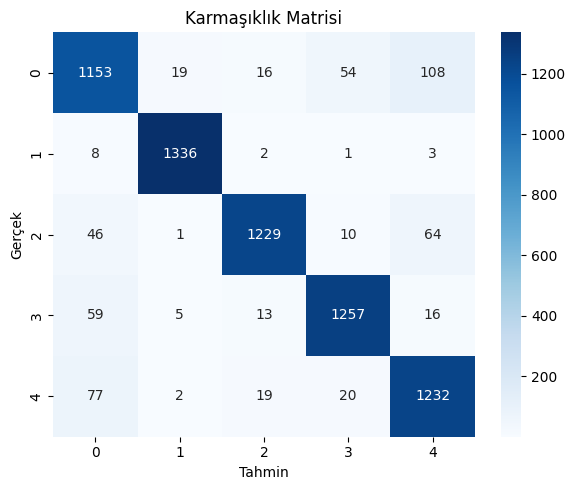

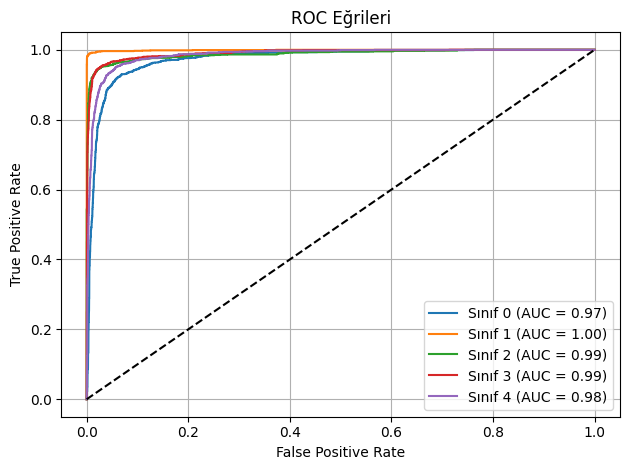

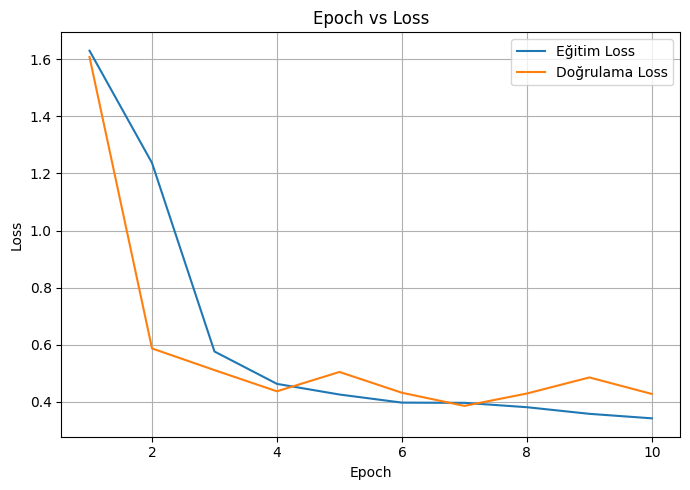

‚úÖ En iyi model ve grafikler Drive'da: /content/drive/MyDrive/best_model_final_roberta_deneme2


In [ ]:
# ‚úÖ Ortamƒ± ayarla
import os
os.environ["WANDB_DISABLED"] = "true"

# ‚úÖ Kurulumlar
!pip install -U transformers datasets scikit-learn evaluate matplotlib seaborn joblib --quiet

# ‚úÖ Drive'ƒ± baƒüla
from google.colab import drive
drive.mount('/content/drive')

# ‚úÖ K√ºt√ºphaneler
import json
import time
import joblib
import shutil
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import LabelEncoder

from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback,
    DataCollatorWithPadding, AutoConfig
)

# ‚úÖ Dosya yollarƒ±
train_path = "/content/drive/MyDrive/train_70_30_final_cleaned_son.json"
val_path = "/content/drive/MyDrive/val_70_30_final_cleaned_son.json"
temp_path = "/content/temp_model"
final_path = "/content/drive/MyDrive/best_model_final_roberta_deneme2"
graph_path = os.path.join(final_path, "grafikler")

os.makedirs(temp_path, exist_ok=True)
os.makedirs(graph_path, exist_ok=True)

# ‚úÖ Model
model_name = "xlm-roberta-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("üñ•Ô∏è Kullanƒ±lan cihaz:", device)

# ‚úÖ JSON'dan oku
with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)

# ‚úÖ Etiket kodla
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["konu"])
val_df["label"] = label_encoder.transform(val_df["konu"])

train_df = train_df[["islenmis_siir", "label"]]
val_df = val_df[["islenmis_siir", "label"]]

# ‚úÖ Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
def tokenize(example):
    return tokenizer(example["islenmis_siir"], padding="max_length", truncation=True, max_length=512)

train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True)
val_ds = Dataset.from_pandas(val_df).map(tokenize, batched=True)

# ‚úÖ Model
config = AutoConfig.from_pretrained(model_name, num_labels=len(label_encoder.classes_),
                                    hidden_dropout_prob=0.4, attention_probs_dropout_prob=0.3)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config).to(device)
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# ‚úÖ Metrikler
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    probs = torch.softmax(torch.tensor(p.predictions), dim=1).numpy()
    cm = confusion_matrix(labels, preds)
    num_classes = len(np.unique(labels))
    specificity_list = []
    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity_list.append(specificity)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro", zero_division=0),
        "recall": recall_score(labels, preds, average="macro", zero_division=0),
        "specificity": np.mean(specificity_list),
        "f1": f1_score(labels, preds, average="macro"),
        "auc": roc_auc_score(labels, probs, multi_class="ovo")
    }

# ‚úÖ Eƒüitim ayarlarƒ±
training_args = TrainingArguments(
    output_dir=temp_path,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    report_to=[],
    learning_rate=5e-6,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=50,
    weight_decay=0.1,
    warmup_ratio=0.05,
    lr_scheduler_type="cosine",
    fp16=True,
    gradient_checkpointing=True,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=1
)

# ‚úÖ Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# ‚úÖ Eƒüitim
start = time.time()
trainer.train()
end = time.time()

print(f"‚è±Ô∏è Eƒüitim s√ºresi: {end - start:.2f} saniye")
print(f"üìå Bitirilen epoch: {trainer.state.epoch:.1f}")

# ‚úÖ En iyi modeli ve label encoder'ƒ± Drive'a kaydet
trainer.save_model(final_path)
joblib.dump(label_encoder, os.path.join(final_path, "label_encoder.pkl"))

# ‚úÖ Tahminler
predictions = trainer.predict(val_ds)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

# ‚úÖ Karma≈üƒ±klƒ±k Matrisi
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Karma≈üƒ±klƒ±k Matrisi")
plt.xlabel("Tahmin")
plt.ylabel("Ger√ßek")
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "confusion_matrix.png"))
plt.show()

# ‚úÖ ROC Eƒürileri
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve((labels == i).astype(int), probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f"Sƒ±nƒ±f {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Eƒürileri")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "roc_curves.png"))
plt.show()

# ‚úÖ Epoch vs Loss
metrics = trainer.state.log_history
train_losses = [m["loss"] for m in metrics if "loss" in m and "eval_loss" not in m]
eval_losses = [m["eval_loss"] for m in metrics if "eval_loss" in m]
epochs = list(range(1, len(eval_losses) + 1))

plt.figure(figsize=(7, 5))
plt.plot(epochs, train_losses[:len(epochs)], label="Eƒüitim Loss")
plt.plot(epochs, eval_losses, label="Doƒürulama Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "epoch_loss.png"))
plt.show()

print(f"‚úÖ En iyi model ve grafikler Drive'da: {final_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
üñ•Ô∏è Kullanƒ±lan cihaz: cuda
üìè Max Length: 181


Map:   0%|          | 0/15744 [00:00<?, ? examples/s]

Map:   0%|          | 0/6750 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-6-763350410.py:135: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


‚è±Ô∏è Eƒüitim s√ºresi: 2092.78 saniye
üìå Bitirilen epoch: 18.0


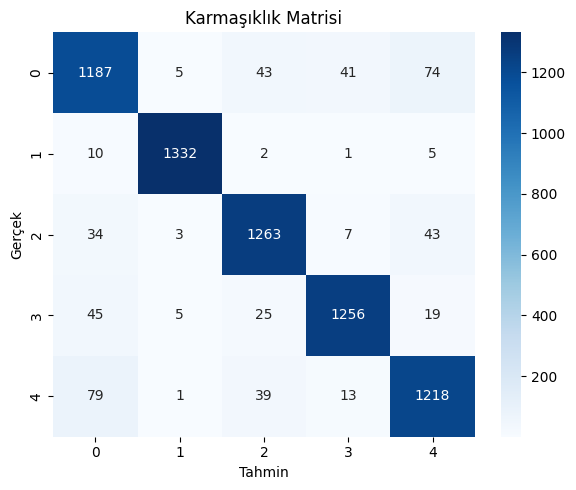

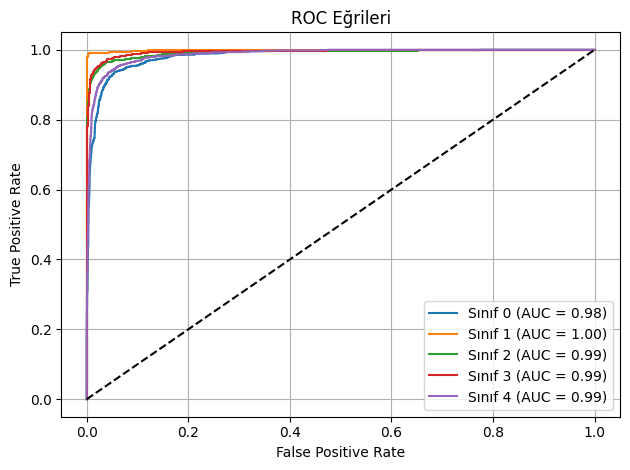

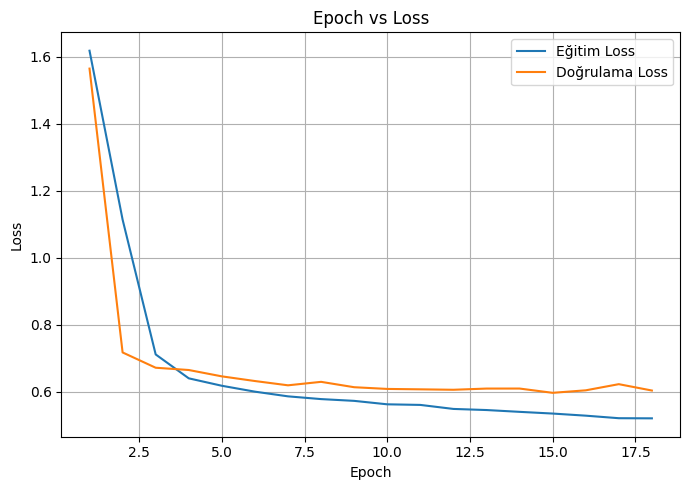

‚úÖ En iyi model ve grafikler Drive'a kaydedildi: /content/drive/MyDrive/best_model_final_roberta_opt


In [ ]:
# ‚úÖ Ortamƒ± ayarla
import os
os.environ["WANDB_DISABLED"] = "true"

# ‚úÖ Kurulumlar
!pip install -U transformers datasets scikit-learn evaluate matplotlib seaborn joblib --quiet

# ‚úÖ Drive baƒülantƒ±sƒ±
from google.colab import drive
drive.mount('/content/drive')

# ‚úÖ K√ºt√ºphaneler
import json
import time
import joblib
import shutil
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import LabelEncoder

from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback,
    DataCollatorWithPadding, AutoConfig
)

# ‚úÖ Dosya yollarƒ±
train_path = "/content/drive/MyDrive/train_70_30_final_cleaned_son.json"
val_path = "/content/drive/MyDrive/val_70_30_final_cleaned_son.json"
temp_path = "/content/temp_model"
final_path = "/content/drive/MyDrive/best_model_final_roberta_opt"
graph_path = os.path.join(final_path, "grafikler")

os.makedirs(temp_path, exist_ok=True)
os.makedirs(graph_path, exist_ok=True)

# ‚úÖ Model
model_name = "xlm-roberta-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("üñ•Ô∏è Kullanƒ±lan cihaz:", device)

# ‚úÖ JSON'dan oku
with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)

# ‚úÖ Etiket kodla
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["konu"])
val_df["label"] = label_encoder.transform(val_df["konu"])
train_df = train_df[["islenmis_siir", "label"]]
val_df = val_df[["islenmis_siir", "label"]]

# ‚úÖ Maksimum uzunluƒüu otomatik hesapla (90. persentil)
lengths = train_df["islenmis_siir"].str.split().apply(len)
max_len = int(lengths.quantile(0.90))
print(f"üìè Max Length: {max_len}")

# ‚úÖ Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
def tokenize(example):
    return tokenizer(example["islenmis_siir"], padding="max_length", truncation=True, max_length=max_len)

train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True)
val_ds = Dataset.from_pandas(val_df).map(tokenize, batched=True)

# ‚úÖ Model config
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_),
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3
)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config).to(device)
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# ‚úÖ Metrikler
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    probs = torch.softmax(torch.tensor(p.predictions), dim=1).numpy()
    cm = confusion_matrix(labels, preds)
    num_classes = len(np.unique(labels))
    specificity_list = []
    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity_list.append(specificity)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro", zero_division=0),
        "recall": recall_score(labels, preds, average="macro", zero_division=0),
        "specificity": np.mean(specificity_list),
        "f1": f1_score(labels, preds, average="macro"),
        "auc": roc_auc_score(labels, probs, multi_class="ovo")
    }

# ‚úÖ Eƒüitim ayarlarƒ±
training_args = TrainingArguments(
    output_dir=temp_path,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    report_to=[],
    learning_rate=5e-6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    weight_decay=0.1,
    warmup_ratio=0.05,
    lr_scheduler_type="polynomial",
    fp16=True,
    gradient_checkpointing=True,
    load_best_model_at_end=True,
    label_smoothing_factor=0.1,
    metric_for_best_model="eval_loss",
    save_total_limit=1
)

# ‚úÖ Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# ‚úÖ Eƒüitim ba≈ülat
start = time.time()
trainer.train()
end = time.time()
print(f"‚è±Ô∏è Eƒüitim s√ºresi: {end - start:.2f} saniye")
print(f"üìå Bitirilen epoch: {trainer.state.epoch:.1f}")

# ‚úÖ Model ve label encoder'ƒ± Drive'a kaydet
trainer.save_model(final_path)
joblib.dump(label_encoder, os.path.join(final_path, "label_encoder.pkl"))

# ‚úÖ Tahminler
predictions = trainer.predict(val_ds)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

# ‚úÖ Confusion Matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Karma≈üƒ±klƒ±k Matrisi")
plt.xlabel("Tahmin")
plt.ylabel("Ger√ßek")
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "confusion_matrix.png"))
plt.show()

# ‚úÖ ROC Eƒürileri
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve((labels == i).astype(int), probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure()
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f"Sƒ±nƒ±f {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Eƒürileri")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "roc_curves.png"))
plt.show()

# ‚úÖ Epoch vs Loss
metrics = trainer.state.log_history
train_losses = [m["loss"] for m in metrics if "loss" in m and "eval_loss" not in m]
eval_losses = [m["eval_loss"] for m in metrics if "eval_loss" in m]
epochs = list(range(1, len(eval_losses) + 1))

plt.figure(figsize=(7, 5))
plt.plot(epochs, train_losses[:len(epochs)], label="Eƒüitim Loss")
plt.plot(epochs, eval_losses, label="Doƒürulama Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "epoch_loss.png"))
plt.show()

print(f"‚úÖ En iyi model ve grafikler Drive'a kaydedildi: {final_path}")

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 491.5/491.5 kB 14.6 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12.9/12.9 MB 120.0 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 84.1/84.1 kB 10.3 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8.6/8.6 MB 127.7 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 193.6/193.6 kB 23.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Map:   0%|          | 0/15744 [00:00<?, ? examples/s]

Map:   0%|          | 0/6750 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1-471232713.py:135: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


‚è±Ô∏è Eƒüitim s√ºresi: 2142.47 saniye
üìå Bitirilen epoch: 10.0


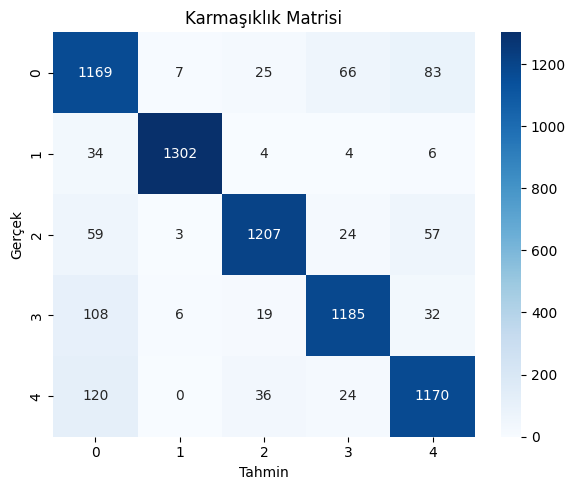

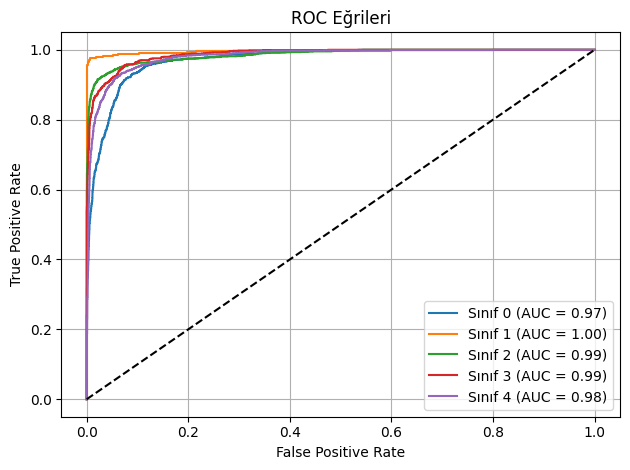

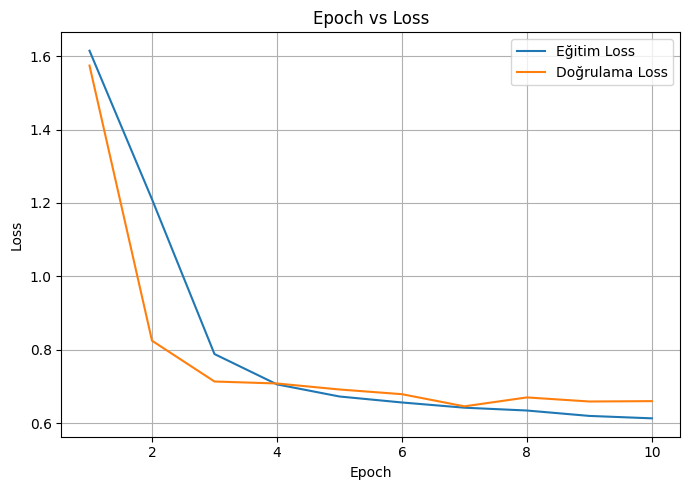

‚úÖ En iyi model ve grafikler Drive'a kaydedildi: /content/drive/MyDrive/best_model_final_roberta_opt_stopwords


In [ ]:
# ‚úÖ Ortamƒ± ayarla
import os
os.environ["WANDB_DISABLED"] = "true"

# ‚úÖ Kurulumlar
!pip install -U transformers datasets scikit-learn evaluate matplotlib seaborn joblib --quiet

# ‚úÖ Drive baƒülantƒ±sƒ±
from google.colab import drive
drive.mount('/content/drive')

# ‚úÖ K√ºt√ºphaneler
import json
import time
import joblib
import shutil
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import LabelEncoder

from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback,
    DataCollatorWithPadding, AutoConfig
)

# ‚úÖ Dosya yollarƒ±
train_path = "/content/drive/MyDrive/train_sonkelime_temiz.json"
val_path   = "/content/drive/MyDrive/val_sonkelime_temiz.json"
temp_path = "/content/temp_model"
final_path = "/content/drive/MyDrive/best_model_final_roberta_opt_stopwords"
graph_path = os.path.join(final_path, "grafikler")

os.makedirs(temp_path, exist_ok=True)
os.makedirs(graph_path, exist_ok=True)

# ‚úÖ Model
model_name = "xlm-roberta-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("üñ•Ô∏è Kullanƒ±lan cihaz:", device)

# ‚úÖ JSON'dan oku
with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)

# ‚úÖ Etiket kodla
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["konu"])
val_df["label"] = label_encoder.transform(val_df["konu"])
train_df = train_df[["islenmis_siir", "label"]]
val_df = val_df[["islenmis_siir", "label"]]

# ‚úÖ Maksimum uzunluƒüu otomatik hesapla (90. persentil)
lengths = train_df["islenmis_siir"].str.split().apply(len)
max_len = int(lengths.quantile(0.90))
print(f"üìè Max Length: {max_len}")

# ‚úÖ Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
def tokenize(example):
    return tokenizer(example["islenmis_siir"], padding="max_length", truncation=True, max_length=max_len)

train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True)
val_ds = Dataset.from_pandas(val_df).map(tokenize, batched=True)

# ‚úÖ Model config
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_),
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3
)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config).to(device)
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# ‚úÖ Metrikler
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    probs = torch.softmax(torch.tensor(p.predictions), dim=1).numpy()
    cm = confusion_matrix(labels, preds)
    num_classes = len(np.unique(labels))
    specificity_list = []
    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity_list.append(specificity)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro", zero_division=0),
        "recall": recall_score(labels, preds, average="macro", zero_division=0),
        "specificity": np.mean(specificity_list),
        "f1": f1_score(labels, preds, average="macro"),
        "auc": roc_auc_score(labels, probs, multi_class="ovo")
    }

# ‚úÖ Eƒüitim ayarlarƒ±
training_args = TrainingArguments(
    output_dir=temp_path,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    report_to=[],
    learning_rate=5e-6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    weight_decay=0.1,
    warmup_ratio=0.05,
    lr_scheduler_type="polynomial",
    fp16=True,
    gradient_checkpointing=True,
    load_best_model_at_end=True,
    label_smoothing_factor=0.1,
    metric_for_best_model="eval_loss",
    save_total_limit=1
)

# ‚úÖ Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# ‚úÖ Eƒüitim ba≈ülat
start = time.time()
trainer.train()
end = time.time()
print(f"‚è±Ô∏è Eƒüitim s√ºresi: {end - start:.2f} saniye")
print(f"üìå Bitirilen epoch: {trainer.state.epoch:.1f}")

# ‚úÖ Model ve label encoder'ƒ± Drive'a kaydet
trainer.save_model(final_path)
joblib.dump(label_encoder, os.path.join(final_path, "label_encoder.pkl"))

# ‚úÖ Tahminler
predictions = trainer.predict(val_ds)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

# ‚úÖ Confusion Matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Karma≈üƒ±klƒ±k Matrisi")
plt.xlabel("Tahmin")
plt.ylabel("Ger√ßek")
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "confusion_matrix.png"))
plt.show()

# ‚úÖ ROC Eƒürileri
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve((labels == i).astype(int), probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure()
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f"Sƒ±nƒ±f {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Eƒürileri")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "roc_curves.png"))
plt.show()

# ‚úÖ Epoch vs Loss
metrics = trainer.state.log_history
train_losses = [m["loss"] for m in metrics if "loss" in m and "eval_loss" not in m]
eval_losses = [m["eval_loss"] for m in metrics if "eval_loss" in m]
epochs = list(range(1, len(eval_losses) + 1))

plt.figure(figsize=(7, 5))
plt.plot(epochs, train_losses[:len(epochs)], label="Eƒüitim Loss")
plt.plot(epochs, eval_losses, label="Doƒürulama Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "epoch_loss.png"))
plt.show()

print(f"‚úÖ En iyi model ve grafikler Drive'a kaydedildi: {final_path}")

In [ ]:
# ‚úÖ Ortamƒ± ayarla
import os
os.environ["WANDB_DISABLED"] = "true"

# ‚úÖ Kurulumlar
!pip install -U transformers datasets scikit-learn evaluate matplotlib seaborn joblib --quiet

# ‚úÖ Drive baƒülantƒ±sƒ±
from google.colab import drive
drive.mount('/content/drive')

# ‚úÖ K√ºt√ºphaneler
import json
import time
import joblib
import shutil
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import LabelEncoder

from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback,
    DataCollatorWithPadding, AutoConfig
)

# ‚úÖ Dosya yollarƒ±
train_path = "/content/drive/MyDrive/train_sonkelime_temiz.json"
val_path   = "/content/drive/MyDrive/val_sonkelime_temiz.json"
temp_path = "/content/temp_model"
final_path = "/content/drive/MyDrive/best_model_final_roberta_opt_stopwords"
graph_path = os.path.join(final_path, "grafikler")

os.makedirs(temp_path, exist_ok=True)
os.makedirs(graph_path, exist_ok=True)

# ‚úÖ Model
model_name = "xlm-roberta-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("üñ•Ô∏è Kullanƒ±lan cihaz:", device)

# ‚úÖ JSON'dan oku
with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)

# ‚úÖ Etiket kodla
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["konu"])
val_df["label"] = label_encoder.transform(val_df["konu"])
train_df = train_df[["islenmis_siir", "label"]]
val_df = val_df[["islenmis_siir", "label"]]

# ‚úÖ Maksimum uzunluƒüu otomatik hesapla (90. persentil)
lengths = train_df["islenmis_siir"].str.split().apply(len)
max_len = int(lengths.quantile(0.90))
print(f"üìè Max Length: {max_len}")

# ‚úÖ Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
def tokenize(example):
    return tokenizer(example["islenmis_siir"], padding="max_length", truncation=True, max_length=max_len)

train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True)
val_ds = Dataset.from_pandas(val_df).map(tokenize, batched=True)

# ‚úÖ Model config
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_),
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3
)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config).to(device)
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# ‚úÖ Metrikler
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    probs = torch.softmax(torch.tensor(p.predictions), dim=1).numpy()
    cm = confusion_matrix(labels, preds)
    num_classes = len(np.unique(labels))
    specificity_list = []
    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity_list.append(specificity)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro", zero_division=0),
        "recall": recall_score(labels, preds, average="macro", zero_division=0),
        "specificity": np.mean(specificity_list),
        "f1": f1_score(labels, preds, average="macro"),
        "auc": roc_auc_score(labels, probs, multi_class="ovo")
    }

# ‚úÖ Eƒüitim ayarlarƒ±
training_args = TrainingArguments(
    output_dir=temp_path,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    report_to=[],
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    weight_decay=0.01,
    warmup_ratio=0.05,
    lr_scheduler_type="cosine",
    fp16=True,
    gradient_checkpointing=True,
    load_best_model_at_end=True,
    label_smoothing_factor=0.1,
    metric_for_best_model="eval_loss",
    save_total_limit=1
)

# ‚úÖ Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# ‚úÖ Eƒüitim ba≈ülat
start = time.time()
trainer.train()
end = time.time()
print(f"‚è±Ô∏è Eƒüitim s√ºresi: {end - start:.2f} saniye")
print(f"üìå Bitirilen epoch: {trainer.state.epoch:.1f}")

# ‚úÖ Model ve label encoder'ƒ± Drive'a kaydet
trainer.save_model(final_path)
joblib.dump(label_encoder, os.path.join(final_path, "label_encoder.pkl"))

# ‚úÖ Tahminler
predictions = trainer.predict(val_ds)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

# ‚úÖ Confusion Matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Karma≈üƒ±klƒ±k Matrisi")
plt.xlabel("Tahmin")
plt.ylabel("Ger√ßek")
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "confusion_matrix.png"))
plt.show()

# ‚úÖ ROC Eƒürileri
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve((labels == i).astype(int), probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure()
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f"Sƒ±nƒ±f {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Eƒürileri")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "roc_curves.png"))
plt.show()

# ‚úÖ Epoch vs Loss
metrics = trainer.state.log_history
train_losses = [m["loss"] for m in metrics if "loss" in m and "eval_loss" not in m]
eval_losses = [m["eval_loss"] for m in metrics if "eval_loss" in m]
epochs = list(range(1, len(eval_losses) + 1))

plt.figure(figsize=(7, 5))
plt.plot(epochs, train_losses[:len(epochs)], label="Eƒüitim Loss")
plt.plot(epochs, eval_losses, label="Doƒürulama Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "epoch_loss.png"))
plt.show()

print(f"‚úÖ En iyi model ve grafikler Drive'a kaydedildi: {final_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
üñ•Ô∏è Kullanƒ±lan cihaz: cuda
üìè Max Length: 162


Map:   0%|          | 0/15744 [00:00<?, ? examples/s]

Map:   0%|          | 0/6750 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3-2677654299.py:135: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


‚è±Ô∏è Eƒüitim s√ºresi: 1072.87 saniye
üìå Bitirilen epoch: 5.0


KeyboardInterrupt: 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
üñ•Ô∏è Kullanƒ±lan cihaz: cuda
üìè Max Length: 162


Map:   0%|          | 0/15744 [00:00<?, ? examples/s]

Map:   0%|          | 0/6750 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4-1127003266.py:134: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


‚è±Ô∏è Eƒüitim s√ºresi: 2360.94 saniye
üìå Bitirilen epoch: 11.0


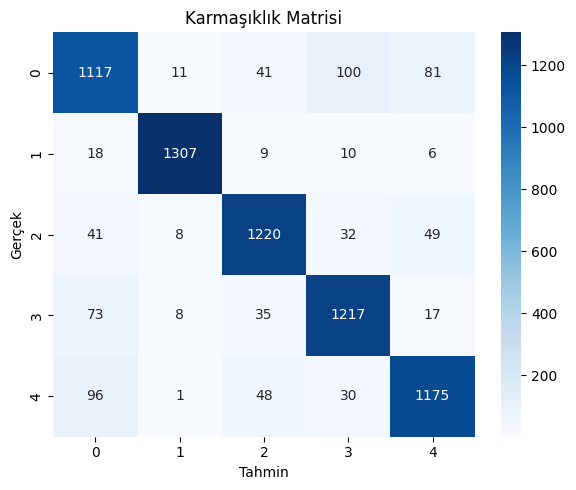

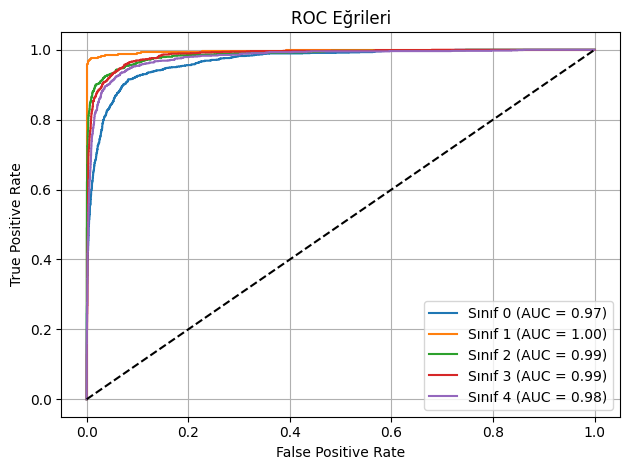

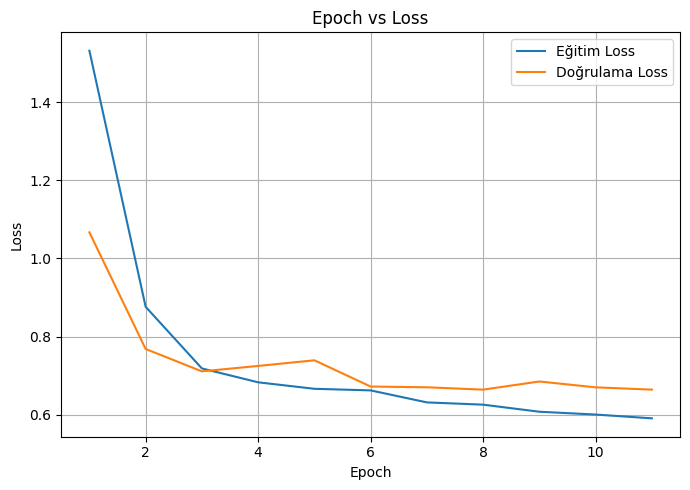

‚úÖ En iyi model ve grafikler Drive'a kaydedildi: /content/drive/MyDrive/best_model_final_roberta_opt_stopwords


In [ ]:
# ‚úÖ Ortamƒ± ayarla
import os
os.environ["WANDB_DISABLED"] = "true"

# ‚úÖ Kurulumlar
!pip install -U transformers datasets scikit-learn evaluate matplotlib seaborn joblib --quiet

# ‚úÖ Drive baƒülantƒ±sƒ±
from google.colab import drive
drive.mount('/content/drive')

# ‚úÖ K√ºt√ºphaneler
import json
import time
import joblib
import shutil
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import LabelEncoder

from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback,
    DataCollatorWithPadding, AutoConfig
)

# ‚úÖ Dosya yollarƒ±
train_path = "/content/drive/MyDrive/train_sonkelime_temiz.json"
val_path   = "/content/drive/MyDrive/val_sonkelime_temiz.json"
temp_path = "/content/temp_model"
final_path = "/content/drive/MyDrive/best_model_final_roberta_opt_stopwords"
graph_path = os.path.join(final_path, "grafikler")

os.makedirs(temp_path, exist_ok=True)
os.makedirs(graph_path, exist_ok=True)

# ‚úÖ Model
model_name = "xlm-roberta-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("üñ•Ô∏è Kullanƒ±lan cihaz:", device)

# ‚úÖ JSON'dan oku
with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)

# ‚úÖ Etiket kodla
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["konu"])
val_df["label"] = label_encoder.transform(val_df["konu"])
train_df = train_df[["islenmis_siir", "label"]]
val_df = val_df[["islenmis_siir", "label"]]

# ‚úÖ Maksimum uzunluƒüu otomatik hesapla (90. persentil)
lengths = train_df["islenmis_siir"].str.split().apply(len)
max_len = int(lengths.quantile(0.90))
print(f"üìè Max Length: {max_len}")

# ‚úÖ Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
def tokenize(example):
    return tokenizer(example["islenmis_siir"], padding="max_length", truncation=True, max_length=max_len)

train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True)
val_ds = Dataset.from_pandas(val_df).map(tokenize, batched=True)

# ‚úÖ Model config
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_),
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3
)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config).to(device)
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# ‚úÖ Metrikler
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    probs = torch.softmax(torch.tensor(p.predictions), dim=1).numpy()
    cm = confusion_matrix(labels, preds)
    num_classes = len(np.unique(labels))
    specificity_list = []
    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity_list.append(specificity)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro", zero_division=0),
        "recall": recall_score(labels, preds, average="macro", zero_division=0),
        "specificity": np.mean(specificity_list),
        "f1": f1_score(labels, preds, average="macro"),
        "auc": roc_auc_score(labels, probs, multi_class="ovo")
    }

# ‚úÖ Eƒüitim ayarlarƒ±
training_args = TrainingArguments(
    output_dir=temp_path,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    report_to=[],
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    weight_decay=0.01,
    warmup_ratio=0.1,
    fp16=True,
    gradient_checkpointing=True,
    load_best_model_at_end=True,
    label_smoothing_factor=0.1,
    metric_for_best_model="eval_loss",
    save_total_limit=1
)

# ‚úÖ Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# ‚úÖ Eƒüitim ba≈ülat
start = time.time()
trainer.train()
end = time.time()
print(f"‚è±Ô∏è Eƒüitim s√ºresi: {end - start:.2f} saniye")
print(f"üìå Bitirilen epoch: {trainer.state.epoch:.1f}")

# ‚úÖ Model ve label encoder'ƒ± Drive'a kaydet
trainer.save_model(final_path)
joblib.dump(label_encoder, os.path.join(final_path, "label_encoder.pkl"))

# ‚úÖ Tahminler
predictions = trainer.predict(val_ds)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

# ‚úÖ Confusion Matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Karma≈üƒ±klƒ±k Matrisi")
plt.xlabel("Tahmin")
plt.ylabel("Ger√ßek")
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "confusion_matrix.png"))
plt.show()

# ‚úÖ ROC Eƒürileri
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve((labels == i).astype(int), probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure()
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f"Sƒ±nƒ±f {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Eƒürileri")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "roc_curves.png"))
plt.show()

# ‚úÖ Epoch vs Loss
metrics = trainer.state.log_history
train_losses = [m["loss"] for m in metrics if "loss" in m and "eval_loss" not in m]
eval_losses = [m["eval_loss"] for m in metrics if "eval_loss" in m]
epochs = list(range(1, len(eval_losses) + 1))

plt.figure(figsize=(7, 5))
plt.plot(epochs, train_losses[:len(epochs)], label="Eƒüitim Loss")
plt.plot(epochs, eval_losses, label="Doƒürulama Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "epoch_loss.png"))
plt.show()

print(f"‚úÖ En iyi model ve grafikler Drive'a kaydedildi: {final_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
üñ•Ô∏è Kullanƒ±lan cihaz: cuda
üìè Max Length: 162


Map:   0%|          | 0/15744 [00:00<?, ? examples/s]

Map:   0%|          | 0/6750 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-5-540384371.py:134: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


‚è±Ô∏è Eƒüitim s√ºresi: 2148.62 saniye
üìå Bitirilen epoch: 10.0


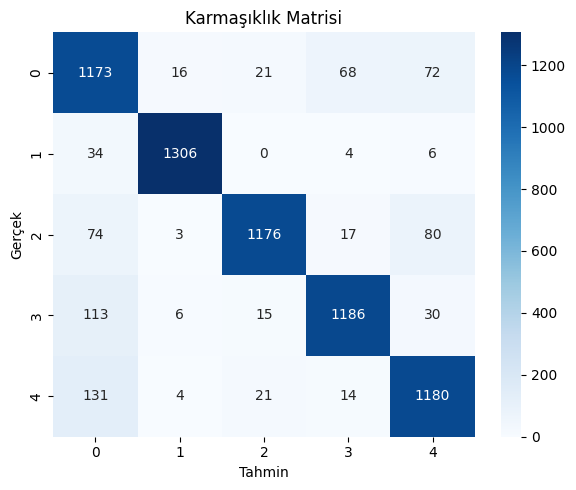

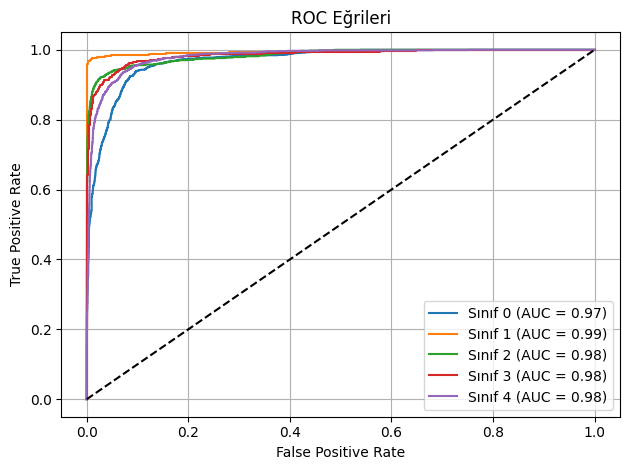

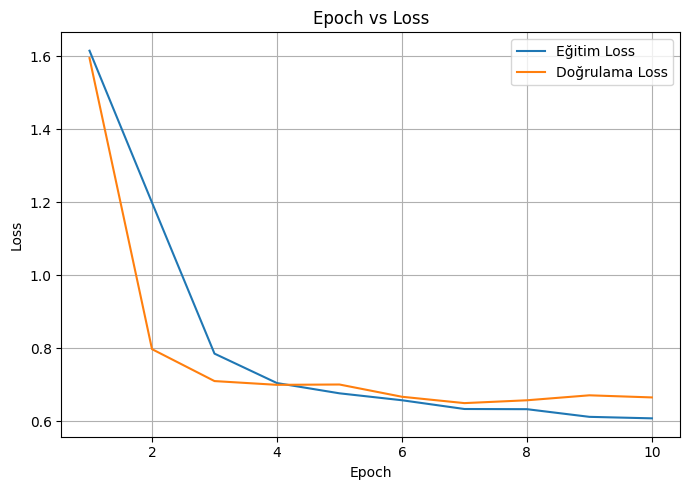

‚úÖ En iyi model ve grafikler Drive'a kaydedildi: /content/drive/MyDrive/best_model_final_roberta_opt_stopwords


In [ ]:
# ‚úÖ Ortamƒ± ayarla
import os
os.environ["WANDB_DISABLED"] = "true"

# ‚úÖ Kurulumlar
!pip install -U transformers datasets scikit-learn evaluate matplotlib seaborn joblib --quiet

# ‚úÖ Drive baƒülantƒ±sƒ±
from google.colab import drive
drive.mount('/content/drive')

# ‚úÖ K√ºt√ºphaneler
import json
import time
import joblib
import shutil
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import LabelEncoder

from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback,
    DataCollatorWithPadding, AutoConfig
)

# ‚úÖ Dosya yollarƒ±
train_path = "/content/drive/MyDrive/train_sonkelime_temiz.json"
val_path   = "/content/drive/MyDrive/val_sonkelime_temiz.json"
temp_path = "/content/temp_model"
final_path = "/content/drive/MyDrive/best_model_final_roberta_opt_stopwords"
graph_path = os.path.join(final_path, "grafikler")

os.makedirs(temp_path, exist_ok=True)
os.makedirs(graph_path, exist_ok=True)

# ‚úÖ Model
model_name = "xlm-roberta-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("üñ•Ô∏è Kullanƒ±lan cihaz:", device)

# ‚úÖ JSON'dan oku
with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)

# ‚úÖ Etiket kodla
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["konu"])
val_df["label"] = label_encoder.transform(val_df["konu"])
train_df = train_df[["islenmis_siir", "label"]]
val_df = val_df[["islenmis_siir", "label"]]

# ‚úÖ Maksimum uzunluƒüu otomatik hesapla (90. persentil)
lengths = train_df["islenmis_siir"].str.split().apply(len)
max_len = int(lengths.quantile(0.90))
print(f"üìè Max Length: {max_len}")

# ‚úÖ Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
def tokenize(example):
    return tokenizer(example["islenmis_siir"], padding="max_length", truncation=True, max_length=max_len)

train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True)
val_ds = Dataset.from_pandas(val_df).map(tokenize, batched=True)

# ‚úÖ Model config
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_),
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3
)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config).to(device)
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# ‚úÖ Metrikler
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    probs = torch.softmax(torch.tensor(p.predictions), dim=1).numpy()
    cm = confusion_matrix(labels, preds)
    num_classes = len(np.unique(labels))
    specificity_list = []
    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity_list.append(specificity)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro", zero_division=0),
        "recall": recall_score(labels, preds, average="macro", zero_division=0),
        "specificity": np.mean(specificity_list),
        "f1": f1_score(labels, preds, average="macro"),
        "auc": roc_auc_score(labels, probs, multi_class="ovo")
    }

# ‚úÖ Eƒüitim ayarlarƒ±
training_args = TrainingArguments(
    output_dir=temp_path,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    report_to=[],
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    weight_decay=0.01,
    warmup_ratio=0.1,
    fp16=True,
    gradient_checkpointing=True,
    load_best_model_at_end=True,
    label_smoothing_factor=0.1,
    metric_for_best_model="eval_loss",
    save_total_limit=1
)

# ‚úÖ Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# ‚úÖ Eƒüitim ba≈ülat
start = time.time()
trainer.train()
end = time.time()
print(f"‚è±Ô∏è Eƒüitim s√ºresi: {end - start:.2f} saniye")
print(f"üìå Bitirilen epoch: {trainer.state.epoch:.1f}")

# ‚úÖ Model ve label encoder'ƒ± Drive'a kaydet
trainer.save_model(final_path)
joblib.dump(label_encoder, os.path.join(final_path, "label_encoder.pkl"))

# ‚úÖ Tahminler
predictions = trainer.predict(val_ds)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

# ‚úÖ Confusion Matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Karma≈üƒ±klƒ±k Matrisi")
plt.xlabel("Tahmin")
plt.ylabel("Ger√ßek")
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "confusion_matrix.png"))
plt.show()

# ‚úÖ ROC Eƒürileri
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve((labels == i).astype(int), probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure()
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f"Sƒ±nƒ±f {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Eƒürileri")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "roc_curves.png"))
plt.show()

# ‚úÖ Epoch vs Loss
metrics = trainer.state.log_history
train_losses = [m["loss"] for m in metrics if "loss" in m and "eval_loss" not in m]
eval_losses = [m["eval_loss"] for m in metrics if "eval_loss" in m]
epochs = list(range(1, len(eval_losses) + 1))

plt.figure(figsize=(7, 5))
plt.plot(epochs, train_losses[:len(epochs)], label="Eƒüitim Loss")
plt.plot(epochs, eval_losses, label="Doƒürulama Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "epoch_loss.png"))
plt.show()

print(f"‚úÖ En iyi model ve grafikler Drive'a kaydedildi: {final_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
üñ•Ô∏è Kullanƒ±lan cihaz: cuda
üìè Max Length: 162


Map:   0%|          | 0/15744 [00:00<?, ? examples/s]

Map:   0%|          | 0/6750 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-6-536792786.py:134: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


‚è±Ô∏è Eƒüitim s√ºresi: 3075.55 saniye
üìå Bitirilen epoch: 14.0


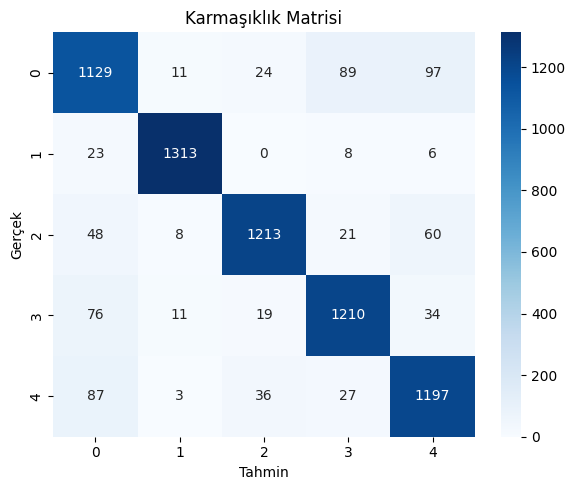

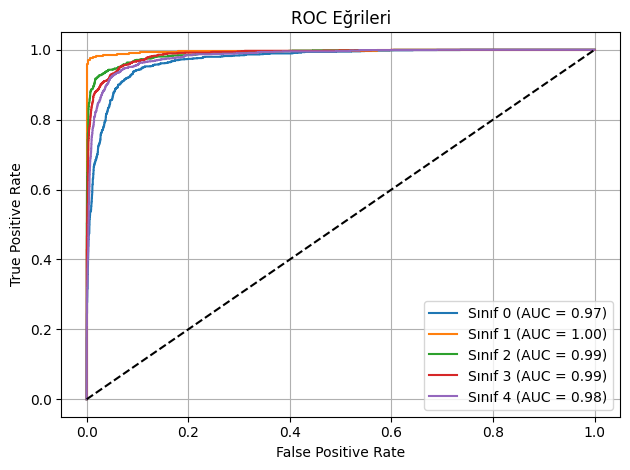

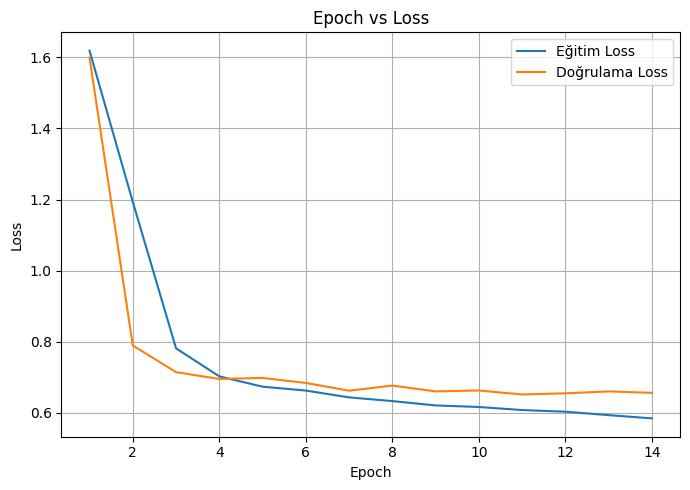

‚úÖ En iyi model ve grafikler Drive'a kaydedildi: /content/drive/MyDrive/best_model_final_roberta_opt_stopwords


In [ ]:
# ‚úÖ Ortamƒ± ayarla
import os
os.environ["WANDB_DISABLED"] = "true"

# ‚úÖ Kurulumlar
!pip install -U transformers datasets scikit-learn evaluate matplotlib seaborn joblib --quiet

# ‚úÖ Drive baƒülantƒ±sƒ±
from google.colab import drive
drive.mount('/content/drive')

# ‚úÖ K√ºt√ºphaneler
import json
import time
import joblib
import shutil
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import LabelEncoder

from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback,
    DataCollatorWithPadding, AutoConfig
)

# ‚úÖ Dosya yollarƒ±
train_path = "/content/drive/MyDrive/train_sonkelime_temiz.json"
val_path   = "/content/drive/MyDrive/val_sonkelime_temiz.json"
temp_path = "/content/temp_model"
final_path = "/content/drive/MyDrive/best_model_final_roberta_opt_stopwords"
graph_path = os.path.join(final_path, "grafikler")

os.makedirs(temp_path, exist_ok=True)
os.makedirs(graph_path, exist_ok=True)

# ‚úÖ Model
model_name = "xlm-roberta-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("üñ•Ô∏è Kullanƒ±lan cihaz:", device)

# ‚úÖ JSON'dan oku
with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)

# ‚úÖ Etiket kodla
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["konu"])
val_df["label"] = label_encoder.transform(val_df["konu"])
train_df = train_df[["islenmis_siir", "label"]]
val_df = val_df[["islenmis_siir", "label"]]

# ‚úÖ Maksimum uzunluƒüu otomatik hesapla (90. persentil)
lengths = train_df["islenmis_siir"].str.split().apply(len)
max_len = int(lengths.quantile(0.90))
print(f"üìè Max Length: {max_len}")

# ‚úÖ Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
def tokenize(example):
    return tokenizer(example["islenmis_siir"], padding="max_length", truncation=True, max_length=max_len)

train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True)
val_ds = Dataset.from_pandas(val_df).map(tokenize, batched=True)

# ‚úÖ Model config
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_),
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3
)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config).to(device)
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# ‚úÖ Metrikler
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    probs = torch.softmax(torch.tensor(p.predictions), dim=1).numpy()
    cm = confusion_matrix(labels, preds)
    num_classes = len(np.unique(labels))
    specificity_list = []
    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity_list.append(specificity)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro", zero_division=0),
        "recall": recall_score(labels, preds, average="macro", zero_division=0),
        "specificity": np.mean(specificity_list),
        "f1": f1_score(labels, preds, average="macro"),
        "auc": roc_auc_score(labels, probs, multi_class="ovo")
    }

# ‚úÖ Eƒüitim ayarlarƒ±
training_args = TrainingArguments(
    output_dir=temp_path,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    report_to=[],
    learning_rate=5e-6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    weight_decay=0.01,
    warmup_ratio=0.05,
    fp16=True,
    gradient_checkpointing=True,
    load_best_model_at_end=True,
    label_smoothing_factor=0.1,
    metric_for_best_model="eval_loss",
    save_total_limit=1
)

# ‚úÖ Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# ‚úÖ Eƒüitim ba≈ülat
start = time.time()
trainer.train()
end = time.time()
print(f"‚è±Ô∏è Eƒüitim s√ºresi: {end - start:.2f} saniye")
print(f"üìå Bitirilen epoch: {trainer.state.epoch:.1f}")

# ‚úÖ Model ve label encoder'ƒ± Drive'a kaydet
trainer.save_model(final_path)
joblib.dump(label_encoder, os.path.join(final_path, "label_encoder.pkl"))

# ‚úÖ Tahminler
predictions = trainer.predict(val_ds)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

# ‚úÖ Confusion Matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Karma≈üƒ±klƒ±k Matrisi")
plt.xlabel("Tahmin")
plt.ylabel("Ger√ßek")
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "confusion_matrix.png"))
plt.show()

# ‚úÖ ROC Eƒürileri
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve((labels == i).astype(int), probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure()
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f"Sƒ±nƒ±f {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Eƒürileri")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "roc_curves.png"))
plt.show()

# ‚úÖ Epoch vs Loss
metrics = trainer.state.log_history
train_losses = [m["loss"] for m in metrics if "loss" in m and "eval_loss" not in m]
eval_losses = [m["eval_loss"] for m in metrics if "eval_loss" in m]
epochs = list(range(1, len(eval_losses) + 1))

plt.figure(figsize=(7, 5))
plt.plot(epochs, train_losses[:len(epochs)], label="Eƒüitim Loss")
plt.plot(epochs, eval_losses, label="Doƒürulama Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "epoch_loss.png"))
plt.show()

print(f"‚úÖ En iyi model ve grafikler Drive'a kaydedildi: {final_path}")

In [ ]:
# ‚úÖ Ortamƒ± ayarla
import os
os.environ["WANDB_DISABLED"] = "true"

# ‚úÖ Kurulumlar
!pip install -U transformers datasets scikit-learn evaluate matplotlib seaborn joblib --quiet

# ‚úÖ Drive baƒülantƒ±sƒ±
from google.colab import drive
drive.mount('/content/drive')

# ‚úÖ K√ºt√ºphaneler
import json
import time
import joblib
import shutil
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import LabelEncoder

from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback,
    DataCollatorWithPadding, AutoConfig
)

# ‚úÖ Dosya yollarƒ±
train_path = "/content/drive/MyDrive/train_sonkelime_temiz.json"
val_path   = "/content/drive/MyDrive/val_sonkelime_temiz.json"
temp_path = "/content/temp_model"
final_path = "/content/drive/MyDrive/best_model_final_roberta_opt_stopwords"
graph_path = os.path.join(final_path, "grafikler")

os.makedirs(temp_path, exist_ok=True)
os.makedirs(graph_path, exist_ok=True)

# ‚úÖ Model
model_name = "xlm-roberta-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("üñ•Ô∏è Kullanƒ±lan cihaz:", device)

# ‚úÖ JSON'dan oku
with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)

# ‚úÖ Etiket kodla
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["konu"])
val_df["label"] = label_encoder.transform(val_df["konu"])
train_df = train_df[["islenmis_siir", "label"]]
val_df = val_df[["islenmis_siir", "label"]]

# ‚úÖ Maksimum uzunluƒüu otomatik hesapla (90. persentil)
lengths = train_df["islenmis_siir"].str.split().apply(len)
max_len = int(lengths.quantile(0.90))
print(f"üìè Max Length: {max_len}")

# ‚úÖ Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
def tokenize(example):
    return tokenizer(example["islenmis_siir"], padding="max_length", truncation=True, max_length=max_len)

train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True)
val_ds = Dataset.from_pandas(val_df).map(tokenize, batched=True)

# ‚úÖ Model config
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_),
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3
)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config).to(device)
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# ‚úÖ Metrikler
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    probs = torch.softmax(torch.tensor(p.predictions), dim=1).numpy()
    cm = confusion_matrix(labels, preds)
    num_classes = len(np.unique(labels))
    specificity_list = []
    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity_list.append(specificity)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro", zero_division=0),
        "recall": recall_score(labels, preds, average="macro", zero_division=0),
        "specificity": np.mean(specificity_list),
        "f1": f1_score(labels, preds, average="macro"),
        "auc": roc_auc_score(labels, probs, multi_class="ovo")
    }

# ‚úÖ Eƒüitim ayarlarƒ±
training_args = TrainingArguments(
    output_dir=temp_path,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    report_to=[],
    learning_rate=5e-6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    weight_decay=0.01,
    warmup_ratio=0.05,
    fp16=True,
    gradient_checkpointing=True,
    load_best_model_at_end=True,
    label_smoothing_factor=0.1,
    metric_for_best_model="eval_loss",
    save_total_limit=1
)

# ‚úÖ Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

# ‚úÖ Eƒüitim ba≈ülat
start = time.time()
trainer.train()
end = time.time()
print(f"‚è±Ô∏è Eƒüitim s√ºresi: {end - start:.2f} saniye")
print(f"üìå Bitirilen epoch: {trainer.state.epoch:.1f}")

# ‚úÖ Model ve label encoder'ƒ± Drive'a kaydet
trainer.save_model(final_path)
joblib.dump(label_encoder, os.path.join(final_path, "label_encoder.pkl"))

# ‚úÖ Tahminler
predictions = trainer.predict(val_ds)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

# ‚úÖ Confusion Matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Karma≈üƒ±klƒ±k Matrisi")
plt.xlabel("Tahmin")
plt.ylabel("Ger√ßek")
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "confusion_matrix.png"))
plt.show()

# ‚úÖ ROC Eƒürileri
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve((labels == i).astype(int), probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure()
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f"Sƒ±nƒ±f {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Eƒürileri")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "roc_curves.png"))
plt.show()

# ‚úÖ Epoch vs Loss
metrics = trainer.state.log_history
train_losses = [m["loss"] for m in metrics if "loss" in m and "eval_loss" not in m]
eval_losses = [m["eval_loss"] for m in metrics if "eval_loss" in m]
epochs = list(range(1, len(eval_losses) + 1))

plt.figure(figsize=(7, 5))
plt.plot(epochs, train_losses[:len(epochs)], label="Eƒüitim Loss")
plt.plot(epochs, eval_losses, label="Doƒürulama Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "epoch_loss.png"))
plt.show()

print(f"‚úÖ En iyi model ve grafikler Drive'a kaydedildi: {final_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
üñ•Ô∏è Kullanƒ±lan cihaz: cuda
üìè Max Length: 162


Map:   0%|          | 0/15744 [00:00<?, ? examples/s]

Map:   0%|          | 0/6750 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-7-1765535583.py:134: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


KeyboardInterrupt: 

In [ ]:
# ‚úÖ Ortamƒ± ayarla
import os
os.environ["WANDB_DISABLED"] = "true"

# ‚úÖ Kurulumlar
!pip install -U transformers datasets scikit-learn evaluate matplotlib seaborn joblib --quiet

# ‚úÖ Drive baƒülantƒ±sƒ±
from google.colab import drive
drive.mount('/content/drive')

# ‚úÖ K√ºt√ºphaneler
import json
import time
import joblib
import shutil
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import LabelEncoder

from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback,
    DataCollatorWithPadding, AutoConfig
)

# ‚úÖ Dosya yollarƒ±
train_path = "/content/drive/MyDrive/train_sonkelime_temiz.json"
val_path   = "/content/drive/MyDrive/val_sonkelime_temiz.json"
temp_path = "/content/temp_model"
final_path = "/content/drive/MyDrive/best_model_final_roberta_opt_stopwords"
graph_path = os.path.join(final_path, "grafikler")

os.makedirs(temp_path, exist_ok=True)
os.makedirs(graph_path, exist_ok=True)

# ‚úÖ Model
model_name = "xlm-roberta-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("üñ•Ô∏è Kullanƒ±lan cihaz:", device)

# ‚úÖ JSON'dan oku
with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)

# ‚úÖ Etiket kodla
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["konu"])
val_df["label"] = label_encoder.transform(val_df["konu"])
train_df = train_df[["islenmis_siir", "label"]]
val_df = val_df[["islenmis_siir", "label"]]

# ‚úÖ Maksimum uzunluƒüu otomatik hesapla (90. persentil)
lengths = train_df["islenmis_siir"].str.split().apply(len)
max_len = int(lengths.quantile(0.90))
print(f"üìè Max Length: {max_len}")

# ‚úÖ Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
def tokenize(example):
    return tokenizer(example["islenmis_siir"], padding="max_length", truncation=True, max_length=max_len)

train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True)
val_ds = Dataset.from_pandas(val_df).map(tokenize, batched=True)

# ‚úÖ Model config
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_),
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3
)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config).to(device)
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# ‚úÖ Metrikler
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    probs = torch.softmax(torch.tensor(p.predictions), dim=1).numpy()
    cm = confusion_matrix(labels, preds)
    num_classes = len(np.unique(labels))
    specificity_list = []
    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity_list.append(specificity)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro", zero_division=0),
        "recall": recall_score(labels, preds, average="macro", zero_division=0),
        "specificity": np.mean(specificity_list),
        "f1": f1_score(labels, preds, average="macro"),
        "auc": roc_auc_score(labels, probs, multi_class="ovo")
    }

# ‚úÖ Eƒüitim ayarlarƒ±
training_args = TrainingArguments(
    output_dir=temp_path,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    report_to=[],
    learning_rate=5e-6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    weight_decay=0.03,
    warmup_ratio=0.05,
    fp16=True,
    gradient_checkpointing=True,
    load_best_model_at_end=True,
    label_smoothing_factor=0.1,
    metric_for_best_model="eval_loss",
    save_total_limit=1
)

# ‚úÖ Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

# ‚úÖ Eƒüitim ba≈ülat
start = time.time()
trainer.train()
end = time.time()
print(f"‚è±Ô∏è Eƒüitim s√ºresi: {end - start:.2f} saniye")
print(f"üìå Bitirilen epoch: {trainer.state.epoch:.1f}")

# ‚úÖ Model ve label encoder'ƒ± Drive'a kaydet
trainer.save_model(final_path)
joblib.dump(label_encoder, os.path.join(final_path, "label_encoder.pkl"))

# ‚úÖ Tahminler
predictions = trainer.predict(val_ds)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

# ‚úÖ Confusion Matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Karma≈üƒ±klƒ±k Matrisi")
plt.xlabel("Tahmin")
plt.ylabel("Ger√ßek")
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "confusion_matrix.png"))
plt.show()

# ‚úÖ ROC Eƒürileri
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve((labels == i).astype(int), probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure()
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f"Sƒ±nƒ±f {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Eƒürileri")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "roc_curves.png"))
plt.show()

# ‚úÖ Epoch vs Loss
metrics = trainer.state.log_history
train_losses = [m["loss"] for m in metrics if "loss" in m and "eval_loss" not in m]
eval_losses = [m["eval_loss"] for m in metrics if "eval_loss" in m]
epochs = list(range(1, len(eval_losses) + 1))

plt.figure(figsize=(7, 5))
plt.plot(epochs, train_losses[:len(epochs)], label="Eƒüitim Loss")
plt.plot(epochs, eval_losses, label="Doƒürulama Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "epoch_loss.png"))
plt.show()

print(f"‚úÖ En iyi model ve grafikler Drive'a kaydedildi: {final_path}")

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 491.5/491.5 kB 12.6 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12.9/12.9 MB 130.2 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 84.1/84.1 kB 7.2 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8.6/8.6 MB 128.5 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 193.6/193.6 kB 19.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires 

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Map:   0%|          | 0/15744 [00:00<?, ? examples/s]

Map:   0%|          | 0/6750 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1-372414549.py:134: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-1-372414549.py", line 147, in <cell line: 0>
    trainer.train()
  File "/usr/local/lib/python3.11/dist-packages/transformers/trainer.py", line 2240, in train
    return inner_training_loop(
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/transformers/trainer.py", line 2555, in _inner_training_loop
    tr_loss_step = self.training_step(model, inputs, num_items_in_batch)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/transformers/trainer.py", line 3791, in training_step
    self.accelerator.backward(loss, **kwargs)
  File "/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py", line 2469, in backward
    self.scaler.scale(loss).backward(**kwargs)
  File

TypeError: object of type 'NoneType' has no len()

In [ ]:
# ‚úÖ Ortamƒ± ayarla
import os
os.environ["WANDB_DISABLED"] = "true"

# ‚úÖ Kurulumlar
!pip install -U transformers datasets scikit-learn evaluate matplotlib seaborn joblib --quiet

# ‚úÖ Drive baƒülantƒ±sƒ±
from google.colab import drive
drive.mount('/content/drive')

# ‚úÖ K√ºt√ºphaneler
import json
import time
import joblib
import shutil
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import LabelEncoder

from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback,
    DataCollatorWithPadding, AutoConfig
)

# ‚úÖ Dosya yollarƒ±
train_path = "/content/drive/MyDrive/train_sonkelime_temiz.json"
val_path   = "/content/drive/MyDrive/val_sonkelime_temiz.json"
temp_path = "/content/temp_model"
final_path = "/content/drive/MyDrive/best_model_final_roberta_opt_stopwords"
graph_path = os.path.join(final_path, "grafikler")

os.makedirs(temp_path, exist_ok=True)
os.makedirs(graph_path, exist_ok=True)

# ‚úÖ Model
model_name = "xlm-roberta-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("üñ•Ô∏è Kullanƒ±lan cihaz:", device)

# ‚úÖ JSON'dan oku
with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)

# ‚úÖ Etiket kodla
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["konu"])
val_df["label"] = label_encoder.transform(val_df["konu"])
train_df = train_df[["islenmis_siir", "label"]]
val_df = val_df[["islenmis_siir", "label"]]

# ‚úÖ Maksimum uzunluƒüu otomatik hesapla (90. persentil)
lengths = train_df["islenmis_siir"].str.split().apply(len)
max_len = int(lengths.quantile(0.90))
print(f"üìè Max Length: {max_len}")

# ‚úÖ Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
def tokenize(example):
    return tokenizer(example["islenmis_siir"], padding="max_length", truncation=True, max_length=max_len)

train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True)
val_ds = Dataset.from_pandas(val_df).map(tokenize, batched=True)

# ‚úÖ Model config
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_),
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.4
)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config).to(device)
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# ‚úÖ Metrikler
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    probs = torch.softmax(torch.tensor(p.predictions), dim=1).numpy()
    cm = confusion_matrix(labels, preds)
    num_classes = len(np.unique(labels))
    specificity_list = []
    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity_list.append(specificity)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro", zero_division=0),
        "recall": recall_score(labels, preds, average="macro", zero_division=0),
        "specificity": np.mean(specificity_list),
        "f1": f1_score(labels, preds, average="macro"),
        "auc": roc_auc_score(labels, probs, multi_class="ovo")
    }

# ‚úÖ Eƒüitim ayarlarƒ±
training_args = TrainingArguments(
    output_dir=temp_path,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    report_to=[],
    learning_rate=3e-6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    weight_decay=0.1,
    warmup_ratio=0.05,
    fp16=True,
    gradient_checkpointing=True,
    load_best_model_at_end=True,
    label_smoothing_factor=0.15,
    metric_for_best_model="eval_loss",
    save_total_limit=1
)

# ‚úÖ Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

# ‚úÖ Eƒüitim ba≈ülat
start = time.time()
trainer.train()
end = time.time()
print(f"‚è±Ô∏è Eƒüitim s√ºresi: {end - start:.2f} saniye")
print(f"üìå Bitirilen epoch: {trainer.state.epoch:.1f}")

# ‚úÖ Model ve label encoder'ƒ± Drive'a kaydet
trainer.save_model(final_path)
joblib.dump(label_encoder, os.path.join(final_path, "label_encoder.pkl"))

# ‚úÖ Tahminler
predictions = trainer.predict(val_ds)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

# ‚úÖ Confusion Matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Karma≈üƒ±klƒ±k Matrisi")
plt.xlabel("Tahmin")
plt.ylabel("Ger√ßek")
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "confusion_matrix.png"))
plt.show()

# ‚úÖ ROC Eƒürileri
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve((labels == i).astype(int), probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure()
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f"Sƒ±nƒ±f {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Eƒürileri")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "roc_curves.png"))
plt.show()

# ‚úÖ Epoch vs Loss
metrics = trainer.state.log_history
train_losses = [m["loss"] for m in metrics if "loss" in m and "eval_loss" not in m]
eval_losses = [m["eval_loss"] for m in metrics if "eval_loss" in m]
epochs = list(range(1, len(eval_losses) + 1))

plt.figure(figsize=(7, 5))
plt.plot(epochs, train_losses[:len(epochs)], label="Eƒüitim Loss")
plt.plot(epochs, eval_losses, label="Doƒürulama Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "epoch_loss.png"))
plt.show()

print(f"‚úÖ En iyi model ve grafikler Drive'a kaydedildi: {final_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
üñ•Ô∏è Kullanƒ±lan cihaz: cuda
üìè Max Length: 162


Map:   0%|          | 0/15744 [00:00<?, ? examples/s]

Map:   0%|          | 0/6750 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2-4013122851.py:134: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


KeyboardInterrupt: 

In [ ]:
import json
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import defaultdict

# Veri yollarƒ±
train_path = "/content/drive/MyDrive/train_sonkelime_temiz.json"
val_path = "/content/drive/MyDrive/val_sonkelime_temiz.json"

# --- 1. T√ºrk√ße E≈üanlamlƒ±lar S√∂zl√ºƒü√º ---
# Bu s√∂zl√ºƒü√º ihtiya√ßlarƒ±nƒ±za g√∂re geni≈ületebilirsiniz.
synonym_dict = defaultdict(list)
synonym_dict.update({
    "a≈ük": ["sevgi", "sevda", "tutku", "a≈üƒ±k", "muhabbet"],
    "y√ºrek": ["kalp", "g√∂n√ºl", "y√ºrek"],
    "gurbet": ["hasret", "√∂zlem", "uzak", "sƒ±la", "dƒ±≈üarƒ±sƒ±"],
    "vatan": ["yurt", "memleket", "toprak"],
    "kahraman": ["yiƒüit", "alp", "cesur", "kahramanlƒ±k"],
    "√∂m√ºr": ["ya≈üam", "hayat", "√∂m√ºr"],
    "√ßile": ["eziyet", "acƒ±", "ƒ±zdƒ±rap", "dert"],
    "g√∂z": ["nazar", "bakar", "g√∂zler"],
    "yolcu": ["yolcu", "gezgin", "seyyah"],
    "t√ºmsek": ["tepe", "y√ºkseklik"],
    "zul√ºm": ["acƒ±masƒ±zlƒ±k", "i≈ükence"],
    "hasret": ["√∂zlem", "gurbet"],
    "daƒü": ["cebel", "sƒ±radaƒü"],
    "acƒ±": ["ƒ±zdƒ±rap", "√ßile"],
    "d√ºnya": ["alem", "cihan", "evren"],
    "insan": ["ki≈üi", "birey", "be≈üer"],
    "dost": ["arkada≈ü", "yolda≈ü", "ahbap"],
    "kader": ["yazgƒ±", "talih"],
    "sessiz": ["sakin", "dingin", "suspus"],
    "ƒ±rmak": ["nehir", "akarsu"],
    "deniz": ["derya", "umman"],
    "g√ºl": ["√ßi√ßek", "gonca"],
    "b√ºlb√ºl": ["≈üakrak", "kanarya"],
    "h√ºrriyet": ["√∂zg√ºrl√ºk", "baƒüƒ±msƒ±zlƒ±k"],
    "sava≈ü": ["harp", "muharebe", "√ßatƒ±≈üma"],
    "zafer": ["galibiyet", "yenme"],
    "≈üair": ["ozan", "dizeler", "≈üiirci"],
    "≈üiir": ["ko≈üuk", "manzume"],
    "m√ºbarek": ["kutlu", "uƒüurlu"],
    "toprak": ["arazi", "yer"],
    "kan": ["dem", "doku"],
    "can": ["ruh", "hayat"],
    "yƒ±l": ["sene"],
    "g√ºn": ["g√ºnd√ºz"],
    "gece": ["leyl"],
    "ƒ±≈üƒ±k": ["nur", "aydƒ±nlƒ±k"],
    "zaman": ["vakit", "√ßaƒü", "devir"],
    "kalp": ["y√ºrek", "g√∂n√ºl", "√ßehre"],
    "umut": ["beklenti", "hayal"],
    "d√º≈üman": ["hasƒ±m", "rakip"],
    "cennet": ["u√ßmak", "adan"],
    "cehennem": ["tamuy"],
    "su": ["ab"],
    "ate≈ü": ["od", "nar"],
    "g√ºne≈ü": ["g√ºn", "h√ºr≈üit"],
    "ay": ["kamer"],
    "yƒ±ldƒ±z": ["ahter"],
    "r√ºzgar": ["yel", "bad"],
    "aƒüa√ß": ["dar", "nebat"],
    "yaprak": ["varak"],
    "ne≈üe": ["sevin√ß", "co≈üku"],
    "keder": ["√ºz√ºnt√º", "gam"],
    "hayal": ["d√º≈ü", "h√ºlya"],
    "bilgi": ["ilim", "malumat"],
    "okul": ["mektep"],
    "√∂ƒüretmen": ["hoca", "muallim"],
    "√∂ƒürenci": ["talebe", "≈üakirt"],
    "ders": ["konu", "et√ºt"],
    "kitap": ["eser", "yazma"],
    "yazmak": ["kaleme almak", "tashih etmek"],
    "okumak": ["m√ºtalaa etmek"],
    "konu≈ümak": ["s√∂ylemek", "demek"],
    "dinlemek": ["kulak vermek"],
    "g√∂rmek": ["bakmak", "seyretmek"],
    "duymak": ["i≈üitmek"],
    "yemek": ["a≈ü", "gƒ±da"],
    "i√ßmek": ["n√ª≈ü etmek"],
    "uyumak": ["horlamak", "uykuya dalmak"],
    "uyanmak": ["g√∂z√ºn√º a√ßmak"],
    "gitmek": ["varmak", "seyahat etmek"],
    "gelmek": ["ula≈ümak", "te≈ürif etmek"],
    "ko≈ümak": ["sprint atmak", "hƒ±zla gitmek"],
    "y√ºr√ºmek": ["adƒ±mlamak", "gezmek"],
    "oturmak": ["ikamet etmek", "√ß√∂kmek"],
    "kalkmak": ["ayaƒüa kalkmak"],
    "sevmek": ["a≈üƒ±k olmak", "beƒüenmek"],
    "nefret": ["kin", "d√º≈ümanlƒ±k"],
    "mutlu": ["mesut", "≈üen"],
    "√ºzg√ºn": ["kederli", "mahzun"],
    "b√ºy√ºk": ["iri", "ulu"],
    "k√º√ß√ºk": ["ufak", "minik"],
    "iyi": ["g√ºzel", "ho≈ü"],
    "k√∂t√º": ["fena", "√ßirkin"],
    "doƒüru": ["hakikat", "ger√ßek"],
    "yanlƒ±≈ü": ["hatalƒ±", "eksik"],
    "sƒ±cak": ["hararetli"],
    "soƒüuk": ["buz gibi", "serin"],
    "hƒ±zlƒ±": ["√ßabuk", "s√ºratli"],
    "yava≈ü": ["aƒüƒ±r", "s√ºr√ºncemeli"],
    "a√ßƒ±k": ["vazƒ±h", "aydƒ±nlƒ±k"],
    "kapalƒ±": ["√∂rt√ºl√º", "mahcup"],
    "yeni": ["cedit", "taze"],
    "eski": ["k√∂hne", "antik"],
    "bol": ["√ßok", "fazla"],
    "az": ["kƒ±t", "eksik"],
    "temiz": ["pak", "saf"],
    "kirli": ["pis", "pasaklƒ±"],
    "zor": ["g√º√ß", "√ßetin"],
    "kolay": ["basit", "rahat"],
    "y√ºksek": ["ali", "y√ºce"],
    "al√ßak": ["pes", "bayaƒüƒ±"],
    "g√ºzel": ["cemil", "h√ºsn√º"],
    "√ßirkin": ["naho≈ü", "mekruh"],
    "sessiz": ["sakin", "dingin"],
    "g√ºr√ºlt√ºl√º": ["patƒ±rtƒ±lƒ±", "cƒ±zƒ±rtƒ±lƒ±"],
    "aydƒ±nlƒ±k": ["ƒ±≈üƒ±klƒ±", "parlak"],
    "karanlƒ±k": ["zulmetli", "siyah"]
})


# --- 2. Veri Artƒ±rma Fonksiyonlarƒ± (EDA) ---

def get_synonyms(word, synonym_dict):
    """Bir kelimenin e≈üanlamlƒ±larƒ±nƒ± d√∂nd√ºr√ºr."""
    return synonym_dict.get(word, [word])

def synonym_replacement(words, n):
    """
    Kelimelerin n kadarƒ±nƒ± e≈üanlamlƒ±larƒ±yla deƒüi≈ütirir.
    words: Liste halinde kelimeler.
    n: Ka√ß kelimenin deƒüi≈ütirileceƒüi.
    """
    new_words = list(words)
    random_word_list = list(set([word for word in words if get_synonyms(word, synonym_dict)]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word, synonym_dict)
        if len(synonyms) > 1:
            synonym = random.choice(list(set(synonyms) - set([random_word])))
            # Kelimenin birden fazla ge√ßtiƒüi durumlarda t√ºm √∂rneklerini deƒüi≈ütirmek yerine ilkini deƒüi≈ütiririz.
            # Daha sofistike bir yakla≈üƒ±m i√ßin t√ºm ge√ßi≈üleri bulup deƒüi≈ütirmek gerekebilir.
            if random_word in new_words:
                idx = new_words.index(random_word)
                new_words[idx] = synonym
                num_replaced += 1
        if num_replaced >= n:
            break
    return ' '.join(new_words)

def random_insertion(words, n):
    """
    Rastgele se√ßilen n tane kelimenin e≈üanlamlƒ±larƒ±nƒ± rastgele yerlere ekler.
    """
    new_words = list(words)
    for _ in range(n):
        word_to_insert = random.choice(words)
        synonyms = get_synonyms(word_to_insert, synonym_dict)
        if synonyms: # E≈üanlamlƒ± varsa
            new_word = random.choice(synonyms)
            new_words.insert(random.randint(0, len(new_words)), new_word)
    return ' '.join(new_words)

def random_swap(words, n):
    """
    n kez rastgele iki kelimenin yerini deƒüi≈ütirir.
    """
    new_words = list(words)
    if len(new_words) < 2: # Takas i√ßin en az 2 kelime olmalƒ±
        return ' '.join(words)
    for _ in range(n):
        idx1, idx2 = random.sample(range(len(new_words)), 2)
        new_words[idx1], new_words[idx2] = new_words[idx2], new_words[idx1]
    return ' '.join(new_words)

def random_deletion(words, p):
    """
    Kelimelerin p olasƒ±lƒ±kla silinmesini saƒülar.
    """
    if len(words) == 1:
        return ' '.join(words)
    new_words = []
    for word in words:
        r = random.uniform(0, 1)
        if r > p:
            new_words.append(word)
    if len(new_words) == 0:
        return random.choice(words) # T√ºm kelimeler silinirse, orijinalden rastgele birini bƒ±rak
    return ' '.join(new_words)

def augment_text(text, num_aug=1):
    """
    Bir metni √ße≈üitli EDA teknikleriyle artƒ±rƒ±r.
    num_aug: Her orijinal metinden ka√ß artƒ±rƒ±lmƒ±≈ü √∂rnek olu≈üturulacaƒüƒ±.
    """
    words = text.split()
    augmented_texts = []
    if not words: # Bo≈ü metinler i√ßin koruma
        return [""] * num_aug

    for _ in range(num_aug):
        aug_text_list = list(words) # Kopyasƒ±nƒ± al

        choice = random.randint(0, 3)
        if choice == 0: # E≈üanlamlƒ± kelime deƒüi≈ütirme
            aug_text_list = synonym_replacement(aug_text_list, max(1, int(len(aug_text_list) * 0.1)))
        elif choice == 1: # Rastgele ekleme
            aug_text_list = random_insertion(aug_text_list, max(1, int(len(aug_text_list) * 0.1)))
        elif choice == 2: # Rastgele takas
            aug_text_list = random_swap(aug_text_list, max(1, int(len(aug_text_list) * 0.1)))
        elif choice == 3: # Rastgele silme
            aug_text_list = random_deletion(aug_text_list, 0.1)

        augmented_texts.append(aug_text_list) # Zaten string olarak d√∂nd√ºr√ºyor

    return augmented_texts


# --- 3. Veri Okuma ve Birle≈ütirme ---

print("Veri setleri okunuyor...")
try:
    with open(train_path, 'r', encoding='utf-8') as f:
        train_data = json.load(f) # Load the entire file as a single JSON object (list of dicts)
    with open(val_path, 'r', encoding='utf-8') as f:
        val_data = json.load(f) # Load the entire file as a single JSON object (list of dicts)
except FileNotFoundError:
    print(f"Hata: Dosya bulunamadƒ±. L√ºtfen '{train_path}' ve '{val_path}' yollarƒ±nƒ± kontrol edin.")
    # Colab kullanƒ±yorsanƒ±z, drive'ƒ± baƒüladƒ±ƒüƒ±nƒ±zdan emin olun:
    # from google.colab import drive
    # drive.mount('/content/drive')
    exit()
except json.JSONDecodeError as e:
    print(f"JSON Decode Hatasƒ±: {e}")
    print("L√ºtfen JSON dosyanƒ±zƒ±n ge√ßerli bir formatta olduƒüundan emin olun.")
    exit()


df_train = pd.DataFrame(train_data)
df_val = pd.DataFrame(val_data)

# Toplam veri setini olu≈üturalƒ±m, b√∂ylece yeniden b√∂lebiliriz.
# Eƒüer test setiniz tamamen ayrƒ± ve hi√ß deƒüi≈ümeyecekse, bu birle≈ütirmeyi yapmayƒ±p sadece train_data'yƒ± artƒ±rƒ±p sonra b√∂lmeniz gerekir.
# Ancak genel yakla≈üƒ±m, train ve val'ƒ± birle≈ütirip artƒ±rma yapƒ±p sonra yeniden b√∂lmektir.
df_combined = pd.concat([df_train, df_val], ignore_index=True)
print(f"Toplam orijinal veri boyutu: {len(df_combined)} √∂rnek.")

# --- 4. Veri Artƒ±rma Uygulamasƒ± ---

print("Eƒüitim verisi artƒ±rƒ±lƒ±yor...")
augmented_records = []
# Her orijinal ≈üiir i√ßin 1 artƒ±rƒ±lmƒ±≈ü √∂rnek olu≈üturacaƒüƒ±z. (num_aug=1)
# Eƒüer daha fazla artƒ±rma istiyorsanƒ±z, num_aug deƒüerini artƒ±rabilirsiniz (√∂rn. num_aug=2).
# Bu durumda veri setiniz (orijinal + num_aug * orijinal) boyutunda olur.
# Mevcut haliyle, her ≈üiirden 1 artƒ±rƒ±lmƒ±≈ü kopya olu≈üturulup orijinalle birle≈ütirilecektir.
for index, row in df_combined.iterrows():
    original_siir = row['islenmis_siir']
    augmented_siirs = augment_text(original_siir, num_aug=1) # Her orijinal i√ßin 1 yeni √∂rnek
    for aug_siir in augmented_siirs:
        augmented_records.append({
            "baslik": row["baslik"],
            "siir": row["siir"],
            "konu": row["konu"],
            "islenmis_siir": aug_siir
        })

df_augmented = pd.DataFrame(augmented_records)

# Orijinal veriyi ve artƒ±rƒ±lmƒ±≈ü veriyi birle≈ütir
df_final_augmented = pd.concat([df_combined, df_augmented], ignore_index=True)
print(f"Veri artƒ±rma sonrasƒ± toplam veri boyutu: {len(df_final_augmented)} √∂rnek.")

# --- 5. Veri B√∂lme ve Kaydetme ---

output_dir = "/content/drive/MyDrive/"

def save_dataframes_to_jsonl(df_train_part, df_val_part, train_filename, val_filename):
    """DataFrame'leri JSONL formatƒ±nda kaydeder."""
    train_output_path = f"{output_dir}{train_filename}"
    val_output_path = f"{output_dir}{val_filename}"

    # Save as JSON (list of objects) instead of JSONL (line-delimited JSON)
    with open(train_output_path, 'w', encoding='utf-8') as f:
        json.dump(df_train_part.to_dict(orient='records'), f, ensure_ascii=False, indent=4)

    with open(val_output_path, 'w', encoding='utf-8') as f:
        json.dump(df_val_part.to_dict(orient='records'), f, ensure_ascii=False, indent=4)

    print(f"Dosyalar kaydedildi: {train_output_path} ve {val_output_path}")


# 5.1. %70 Eƒüitim / %30 Doƒürulama Ayrƒ±mƒ±
print("\n%70 Eƒüitim / %30 Doƒürulama ayrƒ±mƒ± yapƒ±lƒ±yor...")
train_70, val_30 = train_test_split(
    df_final_augmented,
    test_size=0.3,
    stratify=df_final_augmented['konu'], # Konu daƒüƒ±lƒ±mƒ±nƒ± koru
    random_state=42
)
print(f"70/30 Eƒüitim Boyutu: {len(train_70)}, Doƒürulama Boyutu: {len(val_30)}")
save_dataframes_to_jsonl(train_70, val_30, "augmented_train_70_30.json", "augmented_val_70_30.json")

# 5.2. %80 Eƒüitim / %20 Doƒürulama Ayrƒ±mƒ±
print("\n%80 Eƒüitim / %20 Doƒürulama ayrƒ±mƒ± yapƒ±lƒ±yor...")
train_80, val_20 = train_test_split(
    df_final_augmented,
    test_size=0.2,
    stratify=df_final_augmented['konu'], # Konu daƒüƒ±lƒ±mƒ±nƒ± koru
    random_state=42
)
print(f"80/20 Eƒüitim Boyutu: {len(train_80)}, Doƒürulama Boyutu: {len(val_20)}")
save_dataframes_to_jsonl(train_80, val_20, "augmented_train_80_20.json", "augmented_val_80_20.json")

print("\nVeri artƒ±rma ve b√∂lme i≈ülemleri tamamlandƒ±.")
print("≈ûimdi bu yeni JSON dosyalarƒ±nƒ± (√∂rneƒüin augmented_train_80_20.json) eƒüitim kodunuzda kullanabilirsiniz.")

Veri setleri okunuyor...
Toplam orijinal veri boyutu: 22494 √∂rnek.
Eƒüitim verisi artƒ±rƒ±lƒ±yor...
Veri artƒ±rma sonrasƒ± toplam veri boyutu: 44988 √∂rnek.

%70 Eƒüitim / %30 Doƒürulama ayrƒ±mƒ± yapƒ±lƒ±yor...
70/30 Eƒüitim Boyutu: 31491, Doƒürulama Boyutu: 13497
Dosyalar kaydedildi: /content/drive/MyDrive/augmented_train_70_30.json ve /content/drive/MyDrive/augmented_val_70_30.json

%80 Eƒüitim / %20 Doƒürulama ayrƒ±mƒ± yapƒ±lƒ±yor...
80/20 Eƒüitim Boyutu: 35990, Doƒürulama Boyutu: 8998
Dosyalar kaydedildi: /content/drive/MyDrive/augmented_train_80_20.json ve /content/drive/MyDrive/augmented_val_80_20.json

Veri artƒ±rma ve b√∂lme i≈ülemleri tamamlandƒ±.
≈ûimdi bu yeni JSON dosyalarƒ±nƒ± (√∂rneƒüin augmented_train_80_20.json) eƒüitim kodunuzda kullanabilirsiniz.


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# üîπ Eƒüitim ve doƒürulama verilerini DataFrame'e √ßevir
train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)

# üîπ Eƒüitim/Doƒürulama oranƒ±
train_len = len(train_df)
val_len = len(val_df)
total_len = train_len + val_len
train_ratio = train_len / total_len
val_ratio = val_len / total_len

print(f"üîπ Eƒüitim oranƒ±: {train_ratio:.2%}")
print(f"üîπ Doƒürulama oranƒ±: {val_ratio:.2%}")

# üîπ Label sayƒ±mƒ± (her etikette ka√ß tane √∂rnek var)
print("\nüìä Etiket Daƒüƒ±lƒ±mƒ± (Eƒüitim Verisi):")
print(train_df['konu'].value_counts())

print("\nüìä Etiket Daƒüƒ±lƒ±mƒ± (Doƒürulama Verisi):")
print(val_df['konu'].value_counts())

üîπ Eƒüitim oranƒ±: 69.99%
üîπ Doƒürulama oranƒ±: 30.01%

üìä Etiket Daƒüƒ±lƒ±mƒ± (Eƒüitim Verisi):
konu
gurbet         3149
tasavvuf       3149
pastoral       3149
kahramanlƒ±k    3149
a≈ük            3148
Name: count, dtype: int64

üìä Etiket Daƒüƒ±lƒ±mƒ± (Doƒürulama Verisi):
konu
gurbet         1350
a≈ük            1350
kahramanlƒ±k    1350
pastoral       1350
tasavvuf       1350
Name: count, dtype: int64


In [ ]:
# ‚úÖ Ortamƒ± ayarla
import os
os.environ["WANDB_DISABLED"] = "true"

# ‚úÖ Kurulumlar
!pip install -U transformers datasets scikit-learn evaluate matplotlib seaborn joblib --quiet

# ‚úÖ Drive baƒülantƒ±sƒ±
from google.colab import drive
drive.mount('/content/drive')

# ‚úÖ K√ºt√ºphaneler
import json
import time
import joblib
import shutil
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import LabelEncoder

from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback,
    DataCollatorWithPadding, AutoConfig
)

# ‚úÖ Dosya yollarƒ±
train_path = "/content/drive/MyDrive/augmented_train_80_20.json"
val_path = "/content/drive/MyDrive/augmented_val_80_20.json"
temp_path = "/content/temp_model"
final_path = "/content/drive/MyDrive/best_model_final_roberta_opt"
graph_path = os.path.join(final_path, "grafikler")

os.makedirs(temp_path, exist_ok=True)
os.makedirs(graph_path, exist_ok=True)

# ‚úÖ Model
model_name = "xlm-roberta-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("üñ•Ô∏è Kullanƒ±lan cihaz:", device)

# ‚úÖ JSON'dan oku
with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)

# ‚úÖ Etiket kodla
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["konu"])
val_df["label"] = label_encoder.transform(val_df["konu"])
train_df = train_df[["islenmis_siir", "label"]]
val_df = val_df[["islenmis_siir", "label"]]

# ‚úÖ Maksimum uzunluƒüu otomatik hesapla (90. persentil)
lengths = train_df["islenmis_siir"].str.split().apply(len)
max_len = int(lengths.quantile(0.90))
print(f"üìè Max Length: {max_len}")

# ‚úÖ Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
def tokenize(example):
    return tokenizer(example["islenmis_siir"], padding="max_length", truncation=True, max_length=max_len)

train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True)
val_ds = Dataset.from_pandas(val_df).map(tokenize, batched=True)

# ‚úÖ Model config
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_),
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3
)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config).to(device)
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# ‚úÖ Metrikler
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    probs = torch.softmax(torch.tensor(p.predictions), dim=1).numpy()
    cm = confusion_matrix(labels, preds)
    num_classes = len(np.unique(labels))
    specificity_list = []
    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity_list.append(specificity)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro", zero_division=0),
        "recall": recall_score(labels, preds, average="macro", zero_division=0),
        "specificity": np.mean(specificity_list),
        "f1": f1_score(labels, preds, average="macro"),
        "auc": roc_auc_score(labels, probs, multi_class="ovo")
    }

# ‚úÖ Eƒüitim ayarlarƒ±
training_args = TrainingArguments(
    output_dir=temp_path,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    report_to=[],
    learning_rate=5e-6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    weight_decay=0.1,
    warmup_ratio=0.05,
    lr_scheduler_type="polynomial",
    fp16=True,
    gradient_checkpointing=True,
    load_best_model_at_end=True,
    label_smoothing_factor=0.1,
    metric_for_best_model="eval_loss",
    save_total_limit=1
)

# ‚úÖ Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# ‚úÖ Eƒüitim ba≈ülat
start = time.time()
trainer.train()
end = time.time()
print(f"‚è±Ô∏è Eƒüitim s√ºresi: {end - start:.2f} saniye")
print(f"üìå Bitirilen epoch: {trainer.state.epoch:.1f}")

# ‚úÖ Model ve label encoder'ƒ± Drive'a kaydet
trainer.save_model(final_path)
joblib.dump(label_encoder, os.path.join(final_path, "label_encoder.pkl"))

# ‚úÖ Tahminler
predictions = trainer.predict(val_ds)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

# ‚úÖ Confusion Matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Karma≈üƒ±klƒ±k Matrisi")
plt.xlabel("Tahmin")
plt.ylabel("Ger√ßek")
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "confusion_matrix.png"))
plt.show()

# ‚úÖ ROC Eƒürileri
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve((labels == i).astype(int), probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure()
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f"Sƒ±nƒ±f {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Eƒürileri")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "roc_curves.png"))
plt.show()

# ‚úÖ Epoch vs Loss
metrics = trainer.state.log_history
train_losses = [m["loss"] for m in metrics if "loss" in m and "eval_loss" not in m]
eval_losses = [m["eval_loss"] for m in metrics if "eval_loss" in m]
epochs = list(range(1, len(eval_losses) + 1))

plt.figure(figsize=(7, 5))
plt.plot(epochs, train_losses[:len(epochs)], label="Eƒüitim Loss")
plt.plot(epochs, eval_losses, label="Doƒürulama Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "epoch_loss.png"))
plt.show()

print(f"‚úÖ En iyi model ve grafikler Drive'a kaydedildi: {final_path}")

Mounted at /content/drive
üñ•Ô∏è Kullanƒ±lan cihaz: cuda
üìè Max Length: 163


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Map:   0%|          | 0/35990 [00:00<?, ? examples/s]

Map:   0%|          | 0/8998 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2-555040282.py:135: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


‚è±Ô∏è Eƒüitim s√ºresi: 7933.70 saniye
üìå Bitirilen epoch: 17.0


KeyboardInterrupt: 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
üñ•Ô∏è Kullanƒ±lan cihaz: cuda
üìè Max Length: 163


Map:   0%|          | 0/35990 [00:00<?, ? examples/s]

Map:   0%|          | 0/8998 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3-62672579.py:136: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


‚è±Ô∏è Eƒüitim s√ºresi: 13133.83 saniye
üìå Bitirilen epoch: 21.0


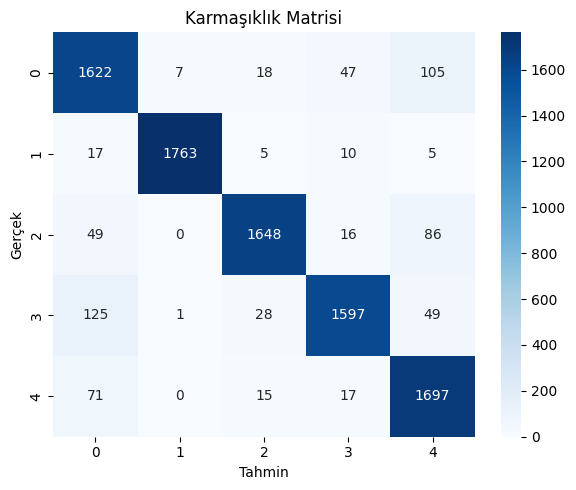

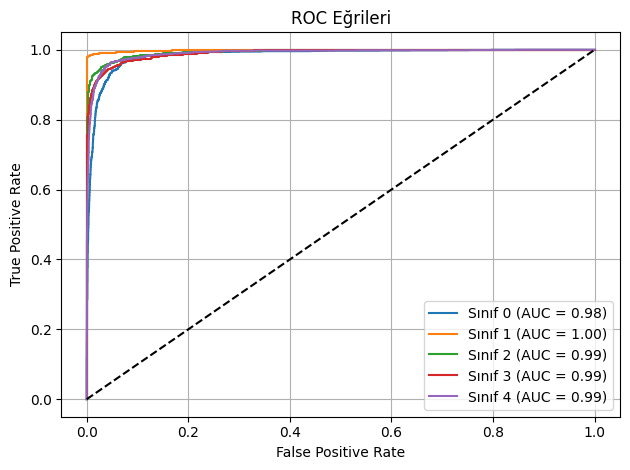

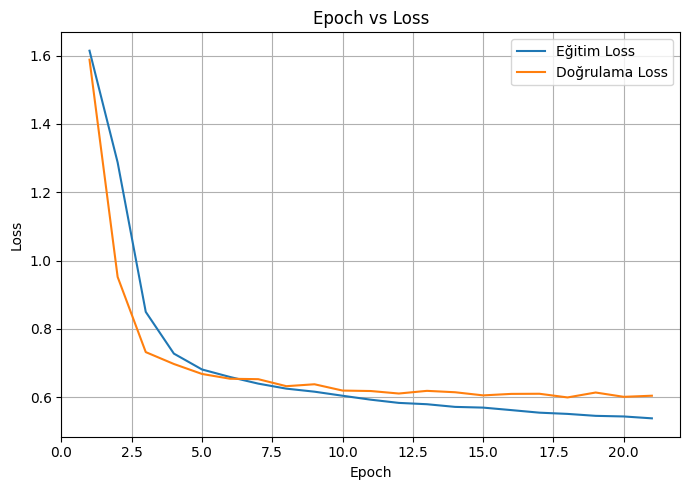

‚úÖ En iyi model ve grafikler Drive'a kaydedildi: /content/drive/MyDrive/best_model_final_roberta_opt


In [ ]:
# ‚úÖ Ortamƒ± ayarla
import os
os.environ["WANDB_DISABLED"] = "true"

# ‚úÖ Kurulumlar
!pip install -U transformers datasets scikit-learn evaluate matplotlib seaborn joblib --quiet

# ‚úÖ Drive baƒülantƒ±sƒ±
from google.colab import drive
drive.mount('/content/drive')

# ‚úÖ K√ºt√ºphaneler
import json
import time
import joblib
import shutil
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import LabelEncoder

from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback,
    DataCollatorWithPadding, AutoConfig
)

# ‚úÖ Dosya yollarƒ±
train_path = "/content/drive/MyDrive/augmented_train_80_20.json"
val_path = "/content/drive/MyDrive/augmented_val_80_20.json"
temp_path = "/content/temp_model"
final_path = "/content/drive/MyDrive/best_model_final_roberta_opt"
graph_path = os.path.join(final_path, "grafikler")

os.makedirs(temp_path, exist_ok=True)
os.makedirs(graph_path, exist_ok=True)

# ‚úÖ Model
model_name = "xlm-roberta-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("üñ•Ô∏è Kullanƒ±lan cihaz:", device)

# ‚úÖ JSON'dan oku
with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)

# ‚úÖ Etiket kodla
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["konu"])
val_df["label"] = label_encoder.transform(val_df["konu"])
train_df = train_df[["islenmis_siir", "label"]]
val_df = val_df[["islenmis_siir", "label"]]

# ‚úÖ Maksimum uzunluƒüu otomatik hesapla (90. persentil)
lengths = train_df["islenmis_siir"].str.split().apply(len)
max_len = int(lengths.quantile(0.90))
print(f"üìè Max Length: {max_len}")

# ‚úÖ Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
def tokenize(example):
    return tokenizer(example["islenmis_siir"], padding="max_length", truncation=True, max_length=max_len)

train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True)
val_ds = Dataset.from_pandas(val_df).map(tokenize, batched=True)

# ‚úÖ Model config
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_),
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3
)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config).to(device)
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# ‚úÖ Metrikler
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    probs = torch.softmax(torch.tensor(p.predictions), dim=1).numpy()
    cm = confusion_matrix(labels, preds)
    num_classes = len(np.unique(labels))
    specificity_list = []
    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity_list.append(specificity)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro", zero_division=0),
        "recall": recall_score(labels, preds, average="macro", zero_division=0),
        "specificity": np.mean(specificity_list),
        "f1": f1_score(labels, preds, average="macro"),
        "auc": roc_auc_score(labels, probs, multi_class="ovo")
    }

# ‚úÖ Eƒüitim ayarlarƒ±
training_args = TrainingArguments(
    output_dir=temp_path,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    report_to=[],
    learning_rate=3e-6,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=50,
    weight_decay=0.1,
    warmup_ratio=0.1,
    gradient_accumulation_steps=2,
    lr_scheduler_type="polynomial",
    fp16=True,
    gradient_checkpointing=True,
    load_best_model_at_end=True,
    label_smoothing_factor=0.1,
    metric_for_best_model="eval_loss",
    save_total_limit=1
)

# ‚úÖ Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# ‚úÖ Eƒüitim ba≈ülat
start = time.time()
trainer.train()
end = time.time()
print(f"‚è±Ô∏è Eƒüitim s√ºresi: {end - start:.2f} saniye")
print(f"üìå Bitirilen epoch: {trainer.state.epoch:.1f}")

# ‚úÖ Model ve label encoder'ƒ± Drive'a kaydet
trainer.save_model(final_path)
joblib.dump(label_encoder, os.path.join(final_path, "label_encoder.pkl"))

# ‚úÖ Tahminler
predictions = trainer.predict(val_ds)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

# ‚úÖ Confusion Matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Karma≈üƒ±klƒ±k Matrisi")
plt.xlabel("Tahmin")
plt.ylabel("Ger√ßek")
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "confusion_matrix.png"))
plt.show()

# ‚úÖ ROC Eƒürileri
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve((labels == i).astype(int), probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure()
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f"Sƒ±nƒ±f {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Eƒürileri")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "roc_curves.png"))
plt.show()

# ‚úÖ Epoch vs Loss
metrics = trainer.state.log_history
train_losses = [m["loss"] for m in metrics if "loss" in m and "eval_loss" not in m]
eval_losses = [m["eval_loss"] for m in metrics if "eval_loss" in m]
epochs = list(range(1, len(eval_losses) + 1))

plt.figure(figsize=(7, 5))
plt.plot(epochs, train_losses[:len(epochs)], label="Eƒüitim Loss")
plt.plot(epochs, eval_losses, label="Doƒürulama Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(graph_path, "epoch_loss.png"))
plt.show()

print(f"‚úÖ En iyi model ve grafikler Drive'a kaydedildi: {final_path}")